# Testing conservation of momentum

> atmos: GFDL-AM4.0.1 (Cubed-sphere (c96) - 1 degree nominal horizontal resolution; 360 x 180 longitude/latitude; 33 levels; top level 1 hPa)
atmosChem: fast chemistry, aerosol only
land: GFDL-LM4.0.1 (1 degree nominal horizontal resolution; 360 x 180 longitude/latitude; 20 levels; bot level 10m); land:Veg:unnamed (dynamic vegetation, dynamic land use); land:Hydro:unnamed (soil water and ice, multi-layer snow, rivers and lakes)
landIce: GFDL-LM4.0.1
ocean: GFDL-OM4p25 (GFDL-MOM6, tripolar - nominal 0.25 deg; 1440 x 1080 longitude/latitude; 75 levels; top grid cell 0-2 m)
ocnBgchem: GFDL-BLINGv2
seaIce: GFDL-SIM4p25 (GFDL-SIS2.0, tripolar - nominal 0.25 deg; 1440 x 1080 longitude/latitude; 5 layers; 5 thickness categories)
(GFDL ID: 2019_0229)

In [10]:
import sys
    # import os
    # # sys.path.append('../')
# from setup import CWD, SCRATCH_DIR, FIG_DIR, DATA_DIR

import polars as pl
import numpy as np
import xarray as xr
from metpy.units import units
import metpy.calc as mpcalc
import metpy.constants as mpconst

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import itertools
import string
import nc_time_axis
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from rich import print

def add_latlon(ax, proj=ccrs.PlateCarree()):
    gl = ax.gridlines(
        crs=proj, draw_labels=True, which='both',
        linewidth=1, color='k', alpha=1, linestyle='--'
    )
    gl.right_labels = None
    gl.top_labels = None
    gl.xlines = None
    gl.ylines = None
    # lon_formatter = LongitudeFormatter(zero_direction_label=True)
    # lat_formatter = LatitudeFormatter()
    # ax.xaxis.set_major_formatter(lon_formatter)
    # ax.yaxis.set_major_formatter(lat_formatter)
    # Increase the ticksize
    gl.xlabel_style = {'size': 10, 'color': 'k', 'rotation':30, 'ha':'right'}
    gl.ylabel_style = {'size': 10, 'color': 'k', 'weight': 'normal'}

def worldmap(da, title, proj=ccrs.Robinson(), kwargs=None):
    fig, ax = plt.subplots(subplot_kw={'projection': proj})
    cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, 'aspect':40, 'format':'%.0e'}
    if kwargs != None:
        da.plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, **kwargs)
    else:
        da.plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs)
    # add_latlon(ax, proj)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.set_title(title)
    plt.show()

def big_ax(ax, lw=2):
    for spine in ax.spines.values():
        spine.set_linewidth(lw)

In [12]:
ds = xr.load_dataset('/scratch/valencig/GPLLJ-Scratch/GFDL-CM4.nc')

In [17]:
ds

<xarray.Dataset> Size: 9GB
Dimensions:    (forcing: 2, time: 13140, plev: 8, lat: 30, lon: 60, bnds: 2)
Coordinates:
  * lat        (lat) float64 240B 11.0 13.0 15.0 17.0 ... 63.0 65.0 67.0 69.0
    lat_bnds   (lat, bnds) float64 480B 10.0 12.0 12.0 14.0 ... 68.0 68.0 70.0
  * lon        (lon) float64 480B 191.2 193.8 196.2 198.8 ... 333.8 336.2 338.8
    lon_bnds   (lon, bnds) float64 960B 190.0 192.5 192.5 ... 337.5 337.5 340.0
  * plev       (plev) float64 64B 1e+05 8.5e+04 7e+04 ... 1e+04 5e+03 1e+03
  * time       (time) object 105kB 1979-01-01 12:00:00 ... 2014-12-31 12:00:00
    time_bnds  (time, bnds) object 210kB 1979-01-01 00:00:00 ... 2015-01-01 0...
    height     float64 8B 10.0
  * forcing    (forcing) <U3 24B '+0K' '+4K'
Dimensions without coordinates: bnds
Data variables: (12/14)
    ua         (forcing, time, plev, lat, lon) float32 2GB -11.08 -10.62 ... nan
    vas        (forcing, time, lat, lon) float32 189MB -4.911 -5.282 ... -12.79
    va         (forcing, time, plev, lat, lon) float32 2GB -5.533 -5.96 ... nan
    zg         (forcing, time, plev, lat, lon) float32 2GB 92.32 92.6 ... nan
    wap        (forcing, time, plev, lat, lon) float32 2GB 0.01152 ... nan
    ta         (forcing, time, plev, lat, lon) float32 2GB 298.0 297.9 ... nan
    ...         ...
    tasmax     (forcing, time, lat, lon) float32 189MB 299.2 299.2 ... nan nan
    prc        (forcing, time, lat, lon) float32 189MB 2.585e-06 ... nan
    tas        (forcing, time, lat, lon) float32 189MB 299.0 298.9 ... 270.9
    tasmin     (forcing, time, lat, lon) float32 189MB 298.7 298.5 ... nan nan
    pr         (forcing, time, lat, lon) float32 189MB 3.32e-06 ... 5.063e-06
    psl        (forcing, time, lat, lon) float32 189MB 1.011e+05 ... 1.016e+05
Attributes: (12/49)
    Conventions:                      CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                      CMIP
    branch_method:                    no parent
    branch_time_in_child:             0.0
    comment:                          <null ref>
    contact:                          gfdl.climate.model.info@noaa.gov
    ...                               ...
    intake_esm_attrs:experiment_id:   amip
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        day
    intake_esm_attrs:grid_label:      gr2
    intake_esm_attrs:version:         20180701
    intake_esm_attrs:_data_format_:   zarr

In [ ]:
import intake
import dask

# Historical query
query = dict(
    experiment_id=['amip', 'amip-p4K'],
    table_id=['Eday'],
    variable_id=['ua', 'va', 'wap', 'zg', 'ta', 'hus'],
    member_id=['r1i1p1f1'],
)
# Can also use from xmip.utils import google_cmip_col
url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)

# if not os.path.exists(CMIP6_FILE):
cat_data = col.search(require_all_on='source_id', **query)
print(cat_data.df['source_id'].unique())
print(cat_data.df['table_id'].unique())
print(cat_data.df['variable_id'].unique())

kwargs = {
    'zarr_kwargs':{
        'consolidated':True,
        'use_cftime':True
    },
    'aggregate':False,
    # 'preprocess':combined_preprocessing
}
ddict = cat_data.to_dataset_dict(**kwargs)

from xmip.postprocessing import merge_variables
ddict_merged = merge_variables(ddict)
merged_keys = list(ddict_merged.keys())
keys = sorted(merged_keys)
print(keys)

In [2]:
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

<GeoAxes: >

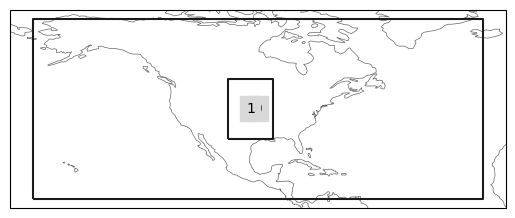

In [5]:
import regionmask 
# conus_bnds = np.array([[-160, 20], [-160,  60], [-30,  60], [-30, 20]])
conus_bnds = np.array([[-170, 10], [-170,  70], [-20,  70], [-20, 10]])
cna_bnds = np.array([[-105, 30], [-105, 50], [-90, 50], [-90, 30]])
names = ["Continental United States", "Great Plains"]
abbrevs = ['CONUS', 'GP']
USregions = regionmask.Regions([conus_bnds, cna_bnds], names=names, abbrevs=abbrevs, name="US", overlap=True)
USregions.plot()

In [3]:
save_file = '/scratch/valencig/GPLLJ-Scratch/GFDL-CM4.nc'
if not os.path.exists(save_file):
    ds_amip = (
        ddict_merged['GFDL-CM4.gr2.amip.Eday.r1i1p1f1']
        .squeeze()
        # .sel(time=slice('2010-06-01', '2010-07-01')) # test one month
        .sel(time=slice(None, '2015-01-01')) # remove the one day in 2015
        .drop_vars(['member_id', 'dcpp_init_year'])
        # .compute()
        # .metpy.parse_cf()
        # .metpy.quantify() # Assign units to everything
        )
    
    ds_p4K = (
    ddict_merged['GFDL-CM4.gr2.amip-p4K.Eday.r1i1p1f1']
        .squeeze()
        # .sel(time=slice('2010-06-01', '2010-07-01')) # test one month
        .sel(time=slice(None, '2015-01-01')) # remove the one day in 2015
        .drop_vars(['member_id', 'dcpp_init_year'])
        # .compute()
        # .metpy.parse_cf()
        # .metpy.quantify() # Assign units to everything
        )
    
    # Merge 
    ds = xr.concat([ds_amip, ds_p4K], dim='forcing').assign_coords(forcing=['+0K', '+4K'])
    mask = USregions.mask_3D(ds.lon, ds.lat)
    ds = ds.where(mask.isel(region=0), drop=True)
    ds.to_netcdf(save_file)

ds = (
    xr.open_dataset(save_file, chunks={'time': 365, 'lat': None, 'lon': None, 'forcing': 1, 'plev':1})
    .metpy.parse_cf()
    .metpy.quantify() # Assign units to everything
)
print(f'Nominal Resolution: {ds.attrs['nominal_resolution']}')
ds['Phi'] = ds.zg * mpconst.earth_gravity
# ds['mixing_ratio'] = mpcalc.mixing_ratio_from_specific_humidity(ds.hus)
# pressure = ds['plev'] * xr.ones_like(ds.ua)
# ds['pressure'] = pressure.transpose(*ds.ua.dims) * units('kg/m/s^2') # Pa
# ds['rho'] = mpcalc.density(ds.pressure, ds.ta, ds.mixing_ratio)
ds = ds.drop_vars('region')
ds

Nominal Resolution: 250 km

<xarray.Dataset> Size: 23GB
Dimensions:    (lat: 30, lon: 56, plev: 19, time: 13140, forcing: 2)
Coordinates:
  * lat        (lat) float64 240B 11.0 13.0 15.0 17.0 ... 63.0 65.0 67.0 69.0
  * lon        (lon) float64 448B 191.2 193.8 196.2 198.8 ... 323.8 326.2 328.8
  * plev       (plev) float64 152B 1e+05 9.25e+04 8.5e+04 ... 1e+03 500.0 100.0
  * time       (time) object 105kB 1979-01-01 12:00:00 ... 2014-12-31 12:00:00
  * forcing    (forcing) <U3 24B '+0K' '+4K'
    abbrevs    <U5 20B 'CONUS'
    names      <U25 100B 'Continental United States'
    metpy_crs  object 8B Projection: latitude_longitude
Data variables:
    hus        (forcing, time, plev, lat, lon) float32 3GB <Quantity(dask.arr...
    wap        (forcing, time, plev, lat, lon) float32 3GB <Quantity(dask.arr...
    ua         (forcing, time, plev, lat, lon) float32 3GB <Quantity(dask.arr...
    va         (forcing, time, plev, lat, lon) float32 3GB <Quantity(dask.arr...
    ta         (forcing, time, plev, lat, lon) float32 3GB <Quantity(dask.arr...
    zg         (forcing, time, plev, lat, lon) float32 3GB <Quantity(dask.arr...
    Phi        (forcing, time, plev, lat, lon) float32 3GB <Quantity(dask.arr...
Attributes: (12/52)
    Conventions:                      CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                      CMIP
    branch_method:                    no parent
    branch_time_in_child:             0.0
    comment:                          <null ref>
    contact:                          gfdl.climate.model.info@noaa.gov
    ...                               ...
    intake_esm_attrs:experiment_id:   amip
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        Eday
    intake_esm_attrs:grid_label:      gr2
    intake_esm_attrs:version:         20180701
    intake_esm_attrs:_data_format_:   zarr

<GeoAxes: >

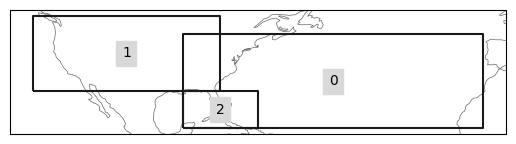

In [5]:
# wave_bnds = np.array([[-130, 30], [-130, 50], [-80, 50], [-80, 30]])
# nash_bnds = np.array([[-90, 20], [-90, 45], [-10, 45], [-10, 20]])
# nash_conus_bnds = np.array([[-90, 20], [-90, 30], [-70, 30], [-70, 20]])
# names = ['NASH Region', 'Wave Region', 'Nash CONUS Region']
# abbrevs = ['NASH', 'Wave', 'nash_conus']
# regions = regionmask.Regions([nash_bnds, wave_bnds, nash_conus_bnds], names=names, abbrevs=abbrevs, name="Regions", overlap=True)
# regions.plot()

## Annual cycle of winds

In [8]:
mask = USregions.mask_3D(ds.lon, ds.lat)
cna = ds.where(mask.isel(region=1), drop=True).compute()
cna['pwind'] = np.sqrt(cna.ua **2 + cna.va**2)

[########################################] | 100% Completed | 210.47 s


In [ ]:
weights = np.cos(np.deg2rad(ds.lat))
monthly_mean = cna.weighted(weights).mean(['lat', 'lon']).groupby("time.month").mean()
n_months = len(cna.time)/12 # obs per month (assume all months are the same length)
monthly_err = cna.weighted(weights).mean(['lat', 'lon']).groupby('time.month').std()/np.sqrt(n_months) * 1.96

In [13]:
forcing_sel = '+0K'

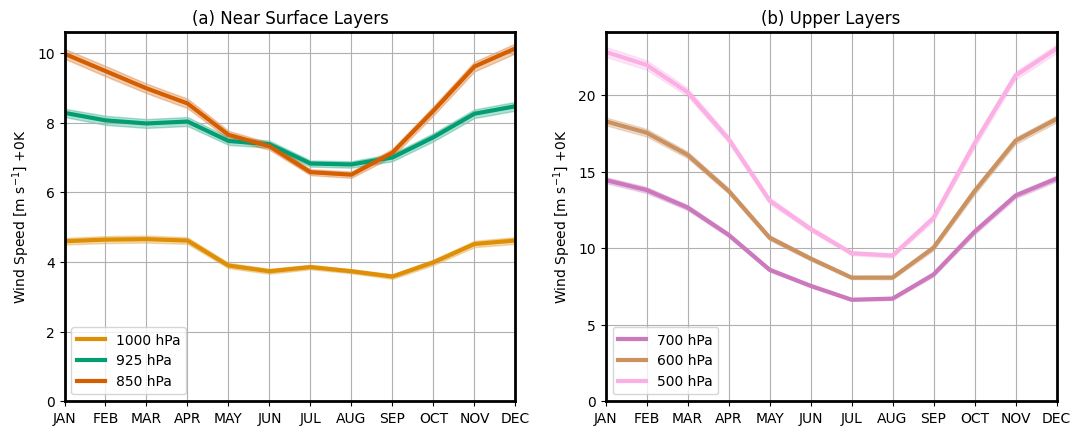

In [14]:
palette = itertools.cycle(sns.color_palette('colorblind'))
c = next(palette)

fig, axes = plt.subplots(ncols=2, figsize=(6.4*2, 4.8))

x = np.arange(1, 13)

### Surface and lower layer
ax = axes[0]
ax.set_title('(a) Near Surface Layers')

for lev in [1000,  925,  850]:
    c = next(palette)
    mean = monthly_mean.pwind.sel(plev=lev*100, forcing=forcing_sel)
    err = monthly_err.pwind.sel(plev=lev*100, forcing=forcing_sel)
    ax.plot(x, mean, color=c, lw=3, label=f'{lev} hPa')
    ax.fill_between(x, mean-err, mean+err, color=c, alpha=0.3)

### Upper layers
ax = axes[1]
ax.set_title('(b) Upper Layers')
for lev in [700,  600,  500]:
    c = next(palette)
    mean = monthly_mean.pwind.sel(plev=lev*100, forcing=forcing_sel)
    err = monthly_err.pwind.sel(plev=lev*100, forcing=forcing_sel)
    ax.plot(x, mean, color=c, lw=3, label=f'{lev} hPa')
    ax.fill_between(x, mean-err, mean+err, color=c, alpha=0.3)
    
for ax in axes:
    ax.set_ylabel(r'Wind Speed [m s$^{-1}$] '+forcing_sel)
    # ax.set_title(f'({string.ascii_lowercase[i]}) {plev} hPa')
    ax.grid()
    big_ax(ax)
    # ax.set_ylim(-25, 30)
    ax.legend()
    ax.set_xlim(1, 12)
    ax.set_ylim(0, None)
    ax.set_xticks(x)
    ax.set_xticklabels(['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'])

plt.show()

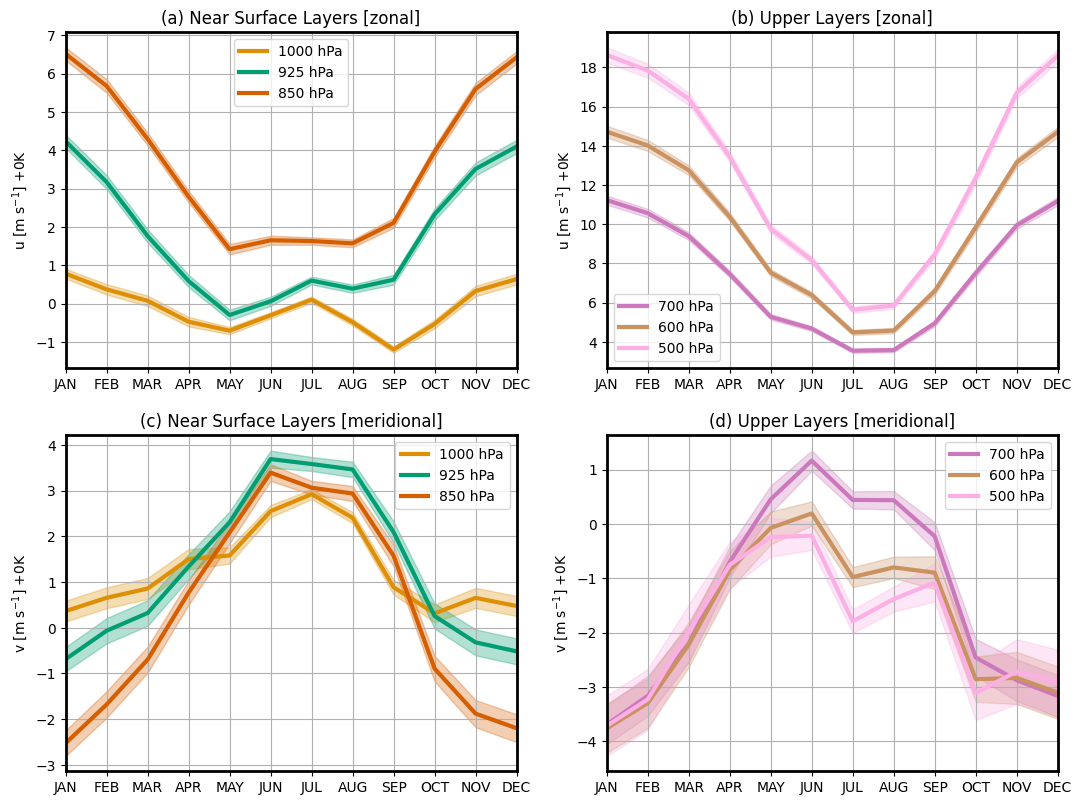

In [15]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(6.4*2, 4.8*2))
x = np.arange(1, 13)

### Surface and lower layer [U]
ax = axes[0, 0]
ax.set_title('(a) Near Surface Layers [zonal]')
palette = itertools.cycle(sns.color_palette('colorblind'))
c = next(palette)

for lev in [1000,  925, 850]:
    c = next(palette)
    mean = monthly_mean.ua.sel(plev=lev*100, forcing=forcing_sel)
    err = monthly_err.ua.sel(plev=lev*100, forcing=forcing_sel)
    ax.plot(x, mean, color=c, lw=3, label=f'{lev} hPa')
    ax.fill_between(x, mean-err, mean+err, color=c, alpha=0.3)

ax.set_ylabel(r'u [m s$^{-1}$] '+forcing_sel)

### Upper layers [U]
ax = axes[0, 1]
ax.set_title('(b) Upper Layers [zonal]')
for lev in [700,  600,  500]:
    c = next(palette)
    mean = monthly_mean.ua.sel(plev=lev*100, forcing=forcing_sel)
    err = monthly_err.ua.sel(plev=lev*100, forcing=forcing_sel)
    ax.plot(x, mean, color=c, lw=3, label=f'{lev} hPa')
    ax.fill_between(x, mean-err, mean+err, color=c, alpha=0.3)
ax.set_ylabel(r'u [m s$^{-1}$] '+forcing_sel)

### Surface and lower layer [V]
palette = itertools.cycle(sns.color_palette('colorblind'))
c = next(palette)

ax = axes[1, 0]
ax.set_title('(c) Near Surface Layers [meridional]')

for lev in [1000,  925, 850]:
    c = next(palette)
    mean = monthly_mean.va.sel(plev=lev*100, forcing=forcing_sel)
    err = monthly_err.va.sel(plev=lev*100, forcing=forcing_sel)
    ax.plot(x, mean, color=c, lw=3, label=f'{lev} hPa')
    ax.fill_between(x, mean-err, mean+err, color=c, alpha=0.3)
ax.set_ylabel(r'v [m s$^{-1}$] '+forcing_sel)

### Upper layers [V]
ax = axes[1, 1]
ax.set_title('(d) Upper Layers [meridional]')
for lev in [700,  600,  500]:
    c = next(palette)
    mean = monthly_mean.va.sel(plev=lev*100, forcing=forcing_sel)
    err = monthly_err.va.sel(plev=lev*100, forcing=forcing_sel)
    ax.plot(x, mean, color=c, lw=3, label=f'{lev} hPa')
    ax.fill_between(x, mean-err, mean+err, color=c, alpha=0.3)

ax.set_ylabel(r'v [m s$^{-1}$] '+forcing_sel)
    
for ax in axes.flatten():
    # ax.set_ylabel(r'Wind [m s$^{-1}$]')
    # ax.set_title(f'({string.ascii_lowercase[i]}) {plev} hPa')
    ax.grid()
    big_ax(ax)
    # ax.set_ylim(-25, 30)
    ax.legend()
    ax.set_xlim(1, 12)
    # ax.set_ylim(0, None)
    ax.set_xticks(x)
    ax.set_xticklabels(['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'])

plt.show()

### Mean wind at pressure levels

In [51]:
ds_ref_season = cna.sel(forcing='+0K').weighted(weights).mean(['lat', 'lon']).resample(time='QS-DEC').mean()
ds_plus4k_season = cna.sel(forcing='+4K').weighted(weights).mean(['lat', 'lon']).resample(time='QS-DEC').mean()

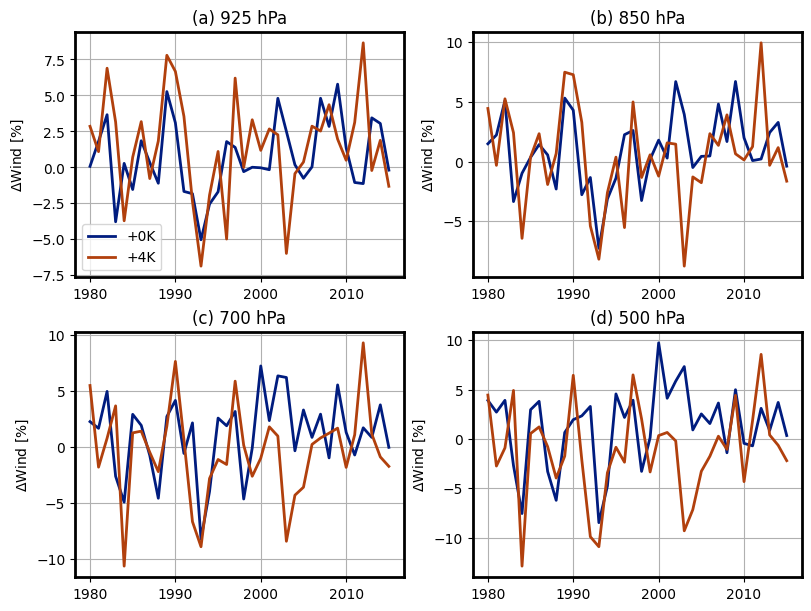

In [63]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), layout='constrained')
ref_subset = cna.sel(forcing='+0K').weighted(weights).mean(['lat', 'lon']).resample(time='1YE').mean()
plus4k_subset = cna.sel(forcing='+4K').weighted(weights).mean(['lat', 'lon']).resample(time='1YE').mean()

for i, plev in enumerate([925, 850, 700, 500]):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    palette = itertools.cycle(sns.color_palette('dark'))
    
    ref_mean = ref_subset.isel(time=slice(0, 20)).mean('time')

    # Normalize and convert to percentage
    ref = (ref_subset/ref_mean - 1) * 100
    plus4k = (plus4k_subset/ref_mean - 1) * 100
    
    # Means (850 hPa)
    ref_mean = ref.pwind.sel(plev=plev*100).to_numpy()
    plus4k_mean = plus4k.pwind.sel(plev=plev*100).to_numpy()
    
    # Errors
    # n_models = len(ref.source_id)
    # ref_err = ref.pwind.sel(plev=plev*100).to_numpy()/np.sqrt(n_models) * 1.96 # z-score for 95% C.I.
    # plus4k_err = plus4k.pwind.sel(plev=plev*100).to_numpy()/np.sqrt(n_models) * 1.96 # z-score for 95% C.I.
    
    # ref
    c = next(palette)
    x = ref_subset.time
    ax.plot(x, ref_mean, color=c, lw=2, label='+0K')
    # ax.fill_between(x, ref_mean-ref_err, ref_mean+ref_err, color=c, alpha=0.3)
    
    # ref
    c = next(palette)
    x = plus4k_subset.time
    ax.plot(x, plus4k_mean, color=c, lw=2, label='+4K')
    # ax.fill_between(x, plus4k_mean-plus4k_err, plus4k_mean+plus4k_err, color=c, alpha=0.3)

    ax.set_ylabel(r'$\Delta$Wind [%]')
    ax.set_title(f'({string.ascii_lowercase[i]}) {plev} hPa')
    ax.grid()
    big_ax(ax)
    # ax.set_ylim(-15, 12)
    if i == 0:
        ax.legend()

plt.show()

## Larger Scale circulation

Holton textbook pg. 98 gives a good overview of why Rocky Mountain Topographically Induced Rossby Wave may be weakening.

### Mean Winds

[########################################] | 100% Completed | 304.80 ms
[########################################] | 100% Completed | 304.27 ms
[########################################] | 100% Completed | 304.46 ms
[########################################] | 100% Completed | 304.26 ms
[########################################] | 100% Completed | 305.10 ms
[########################################] | 100% Completed | 304.47 ms
[########################################] | 100% Completed | 304.53 ms
[########################################] | 100% Completed | 304.66 ms
[########################################] | 100% Completed | 304.56 ms
[########################################] | 100% Completed | 304.70 ms
[########################################] | 100% Completed | 304.72 ms
[########################################] | 100% Completed | 304.47 ms
[########################################] | 100% Completed | 304.88 ms
[########################################] | 100% Completed | 30

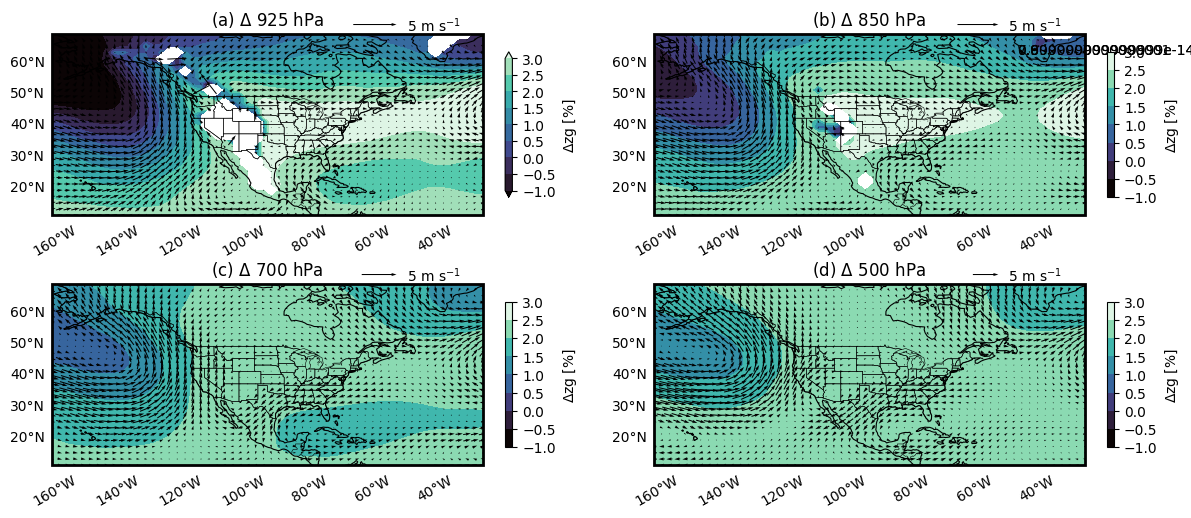

In [80]:
# yearly_wind = ds_conus.resample(time='1YE').mean()
ref = ds.sel(forcing='+0K').mean('time')
perturb = ds.sel(forcing='+4K').mean('time')
diff = perturb - ref

cmap = sns.color_palette("mako", as_cmap=True)

fig, axes = plt.subplots(
    nrows=2, ncols=2, subplot_kw={'projection': ccrs.PlateCarree()},
    layout='constrained', figsize=(12, 5)
)
cbar_kwargs = {'label': r'$\Delta$zg [%]', 'shrink': 0.8}
# +0K wind
for i, lev in enumerate([925, 850, 700, 500]):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    diff_zg = diff.sel(plev=lev*100).zg
    ref_zg = ref.sel(plev=lev*100).zg
    percent_diff = diff_zg/ref_zg*100
    percent_diff.plot.contourf(ax=ax, levels=9, vmin=-1, vmax=3, cmap=cmap, transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs)
    q = diff.sel(plev=lev*100).plot.quiver(
        ax=ax, x='lon', y='lat',
        u='ua',
        v='va',
        transform=ccrs.PlateCarree(), #scale=40
    )
    ref_magnitude = 5
    ax.quiverkey(q, X=0.8, Y=1.05, U=ref_magnitude, label=f'{ref_magnitude}'+' m s$^{-1}$', labelpos='E')
    ax.set_title(f'({string.ascii_lowercase[i]}) '+r'$\Delta$ '+f'{int(lev)} hPa')

for ax in axes.flatten():
    add_latlon(ax)
    big_ax(ax)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.add_feature(cfeature.STATES, linewidth=0.4)
plt.show()

[########################################] | 100% Completed | 202.97 ms
[########################################] | 100% Completed | 202.57 ms
[########################################] | 100% Completed | 203.46 ms
[########################################] | 100% Completed | 201.37 ms
[########################################] | 100% Completed | 202.80 ms
[########################################] | 100% Completed | 202.47 ms
[########################################] | 100% Completed | 201.29 ms
[########################################] | 100% Completed | 202.73 ms
[########################################] | 100% Completed | 202.79 ms
[########################################] | 100% Completed | 202.83 ms
[########################################] | 100% Completed | 202.56 ms
[########################################] | 100% Completed | 202.60 ms
[########################################] | 100% Completed | 203.73 ms
[########################################] | 100% Completed | 20

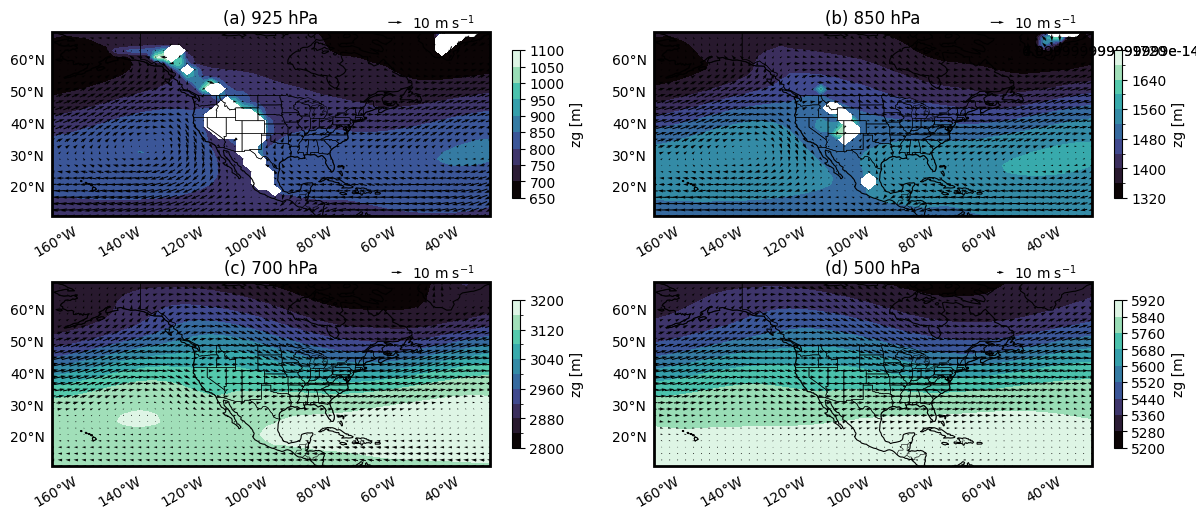

In [76]:
fig, axes = plt.subplots(
    nrows=2, ncols=2, subplot_kw={'projection': ccrs.PlateCarree()},
    layout='constrained', figsize=(12, 5)
)
cbar_kwargs = {'label': 'zg [m]', 'shrink': 0.8}
# +0K wind
for i, lev in enumerate([925, 850, 700, 500]):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    ref.sel(plev=lev*100).zg.plot.contourf(ax=ax, levels=11, cmap=cmap, transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs)
    q = ref.sel(plev=lev*100).plot.quiver(
        ax=ax, x='lon', y='lat',
        u='ua',
        v='va',
        transform=ccrs.PlateCarree(), #scale=40
    )
    ref_magnitude = 10
    ax.quiverkey(q, X=0.8, Y=1.05, U=ref_magnitude, label=f'{ref_magnitude}'+' m s$^{-1}$', labelpos='E')
    ax.set_title(f'({string.ascii_lowercase[i]}) {int(lev)} hPa')

for ax in axes.flatten():
    add_latlon(ax)
    big_ax(ax)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.add_feature(cfeature.STATES, linewidth=0.4)
plt.show()

### Strength of Rossby Wave vs NASH

In [92]:
def wave_properties(ds_wave, zonal_mean):
    time_mean = ds_wave.mean('time')
    deviation = time_mean - zonal_mean
    sEKE = 1/2 * zonal_mean.rho * (deviation.ua**2 + deviation.va**2)
    weights = np.cos(np.deg2rad(sEKE.lat))
    sEKE_integrated = sEKE.sel(plev=slice(850*100, 200*100)).integrate('plev') * -1 # Need -1 factor because integration happens from Low hPa -> 850 hPa
    sEKE_mean = sEKE_integrated.weighted(weights).mean(['lat', 'lon'], skipna=True)
    assert sEKE_mean.metpy.units == units('kg m^{-1} s^{-2}') # J/m^2 # The integration doesn't change the units but get's rid of the 1/m
    return sEKE_mean.values

def nash_strength(ds_nash):
    zg_850 = ds_nash.zg.sel(plev=850*100)
    weights = np.cos(np.deg2rad(zg_850.lat))
    mean_zg = zg_850.weighted(weights).mean(['lat', 'lon', 'time'])
    return mean_zg.values

def center(zg):
    # Bounds to check for NASH western edge: [[-80, 20], [-80, 45], [-10, 45], [-10, 20]]
    mask = (zg.lon>=-80+360)&(zg.lon<=-10+360)&(zg.lat>=20)&(zg.lat<=45)
    zg_nash = zg.where(mask, drop=True)
    zg_850 = zg_nash.sel(plev=850*100)
    max_idx = zg_850.stack(z=('lat', 'lon')).argmax(dim='z')
    lat_lon_coords = xr.apply_ufunc( # Convert the flat index back to lat/lon coordinates
        lambda idx: divmod(idx, len(zg_850.lon)),
        max_idx.chunk(dict(time=-1)),
        vectorize=True,
        dask='parallelized',
        output_dtypes=(int, int),
        input_core_dims=[['time']],
        output_core_dims=[['time'], ['time']],
    )
    lon_values = zg_850.lon[lat_lon_coords[1]].compute()
    return lon_values.mean('time').values, lon_values.std('time').values
    
def western_edge(zg):
    # Bounds to check for NASH western edge: [[-80, 20], [-80, 45], [-10, 45], [-10, 20]]
    mask = (zg.lon>=-80+360)&(zg.lon<=-10+360)&(zg.lat>=20)&(zg.lat<=45)
    zg_nash = zg.where(mask, drop=True)
    zg_850 = zg_nash.sel(plev=850*100)
    max_vals = zg_850.max(['lat', 'lon'])
    masked_percentiles = zg_850.where(zg_850 >= (max_vals-(20*units('m'))))
    western_edge = masked_percentiles.lon.where(masked_percentiles >= 0).min(['lat', 'lon']).compute()
    return western_edge.mean('time').values, western_edge.std('time').values

present = ds_conus.sel(forcing='+0K')
future = ds_conus.sel(forcing='+4K')
mask = regions.mask_3D(ds.lon, ds.lat)

###
# NEED TO RELOAD DATA SO ZONAL IS ACTUALLY THE WHOLE GLOBE
###

### Get Rossby wave
present_wave = present#.where(mask.isel(region=1), drop=True)
future_wave = future#.where(mask.isel(region=1), drop=True)
present_zonal = ds.sel(forcing='+0K').mean(['time', 'lon'])#present.mean(['time', 'lon'])
future_zonal = ds.sel(forcing='+4K').mean(['time', 'lon']) #present.mean(['time', 'lon'])
present_sEKE = wave_properties(present_wave, present_zonal)
future_sEKE = wave_properties(future_wave, future_zonal)
delta_sEKE = future_sEKE-present_sEKE
print(f'delta_sEKE: {round(delta_sEKE/present_sEKE*100, 2)} %')

### Get strength of NASH
present_nash = present.where(mask.isel(region=2), drop=True)
future_nash = future.where(mask.isel(region=2), drop=True)
present_strength = nash_strength(present_nash)
future_strength = nash_strength(future_nash)
delta_nash = future_strength - present_strength
print(f'delta_NASH: {round(delta_nash/present_strength*100, 2)} %')

### Get center of NASH
# present_center, p_c_std = center(ds.sel(forcing='+0K').zg)
# future_center, f_c_std = center(ds.sel(forcing='+4K').zg)
# delta_center = future_center - present_center
# print(f'delta_Center: {round(delta_center, 2)} deg E')

# ### Get western edge of NASH
# present_edge, p_w_std = western_edge(ds.sel(forcing='+0K').zg)
# future_edge, f_w_std = western_edge(ds.sel(forcing='+4K').zg)
# delta_edge = future_edge - present_edge
# print(f'delta_WesternEdge: {round(delta_edge, 2)} deg E')

[########################################] | 100% Completed | 320.24 s
[########################################] | 100% Completed | 321.16 s


delta_sEKE: -7.3 %

delta_NASH: 2.3 %

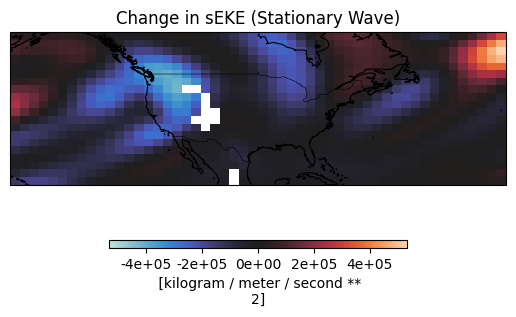

In [44]:
ds_wave = present_wave
zonal_mean = present_zonal
time_mean = ds_wave.mean('time')
deviation = time_mean - zonal_mean
sEKE = 1/2 * zonal_mean.rho * (deviation.ua**2 + deviation.va**2)
weights = np.cos(np.deg2rad(sEKE.lat))
sEKE_present = sEKE.sel(plev=slice(850*100, 200*100)).integrate('plev') * -1

ds_wave = future_wave
zonal_mean = future_zonal
time_mean = ds_wave.mean('time')
deviation = time_mean - zonal_mean
sEKE = 1/2 * zonal_mean.rho * (deviation.ua**2 + deviation.va**2)
weights = np.cos(np.deg2rad(sEKE.lat))
sEKE_future = sEKE.sel(plev=slice(850*100, 200*100)).integrate('plev') * -1

# percent_change = (sEKE_future-sEKE_present)/sEKE_present*100
worldmap(sEKE_future-sEKE_present, 'Change in sEKE (Stationary Wave)', ccrs.PlateCarree(), {'cmap':sns.color_palette("icefire", as_cmap=True)})

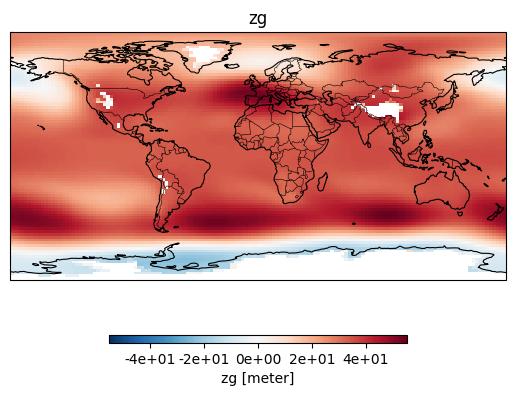

In [87]:
# zg = ds.zg
# mask = (zg.lon>=-80+360)&(zg.lon<=-10+360)&(zg.lat>=20)&(zg.lat<=45)
# present_zg = ds.zg.sel(plev=850*100, forcing='+0K').mean('time').compute()
# future_zg = ds.zg.sel(plev=850*100, forcing='+4K').mean('time').compute()
worldmap((future_zg-present_zg), 'zg', ccrs.PlateCarree())

### Change in zonal mean zonal winds

Wills and Schneider: 
> the amplitude of orographic stationary Rossby waves in these simulations scales roughly with the zonal-mean zonal surface winds because of their influence on orographic vertical winds

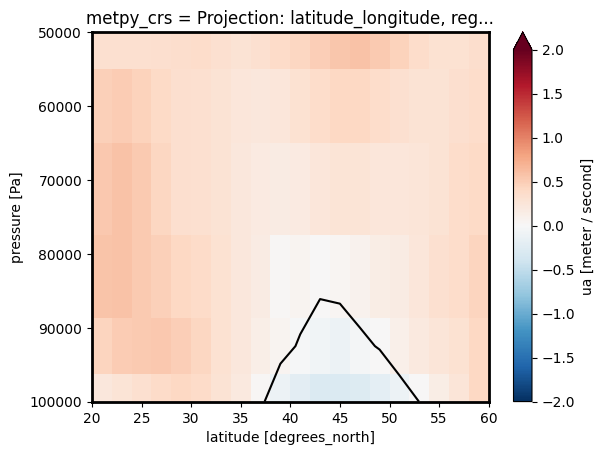

In [91]:
zonal_diff = ds_conus.sel(forcing='+4K').mean(['lon', 'time']) - ds_conus.sel(forcing='+0K').mean(['lon', 'time'])
# zonal_diff = zonal_diff/ds_conus.sel(forcing='+0K').ua.mean(['lon', 'time'])*100
fig, ax = plt.subplots()
zonal_diff.ua.plot(ax=ax,vmin=-2, vmax=2, cmap='RdBu_r')
zonal_diff.ua.plot.contour(ax=ax,vmin=-2, vmax=2, colors='k')
ax.invert_yaxis()
ax.set_ylim(1000*100, 500*100)
big_ax(ax)
plt.show()

### Zonal mean anomalies
like Willis and Schneider (2018)

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x15546b50b7d0>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x155456896930>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x1554c46bcbf0>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x15546adea1e0>


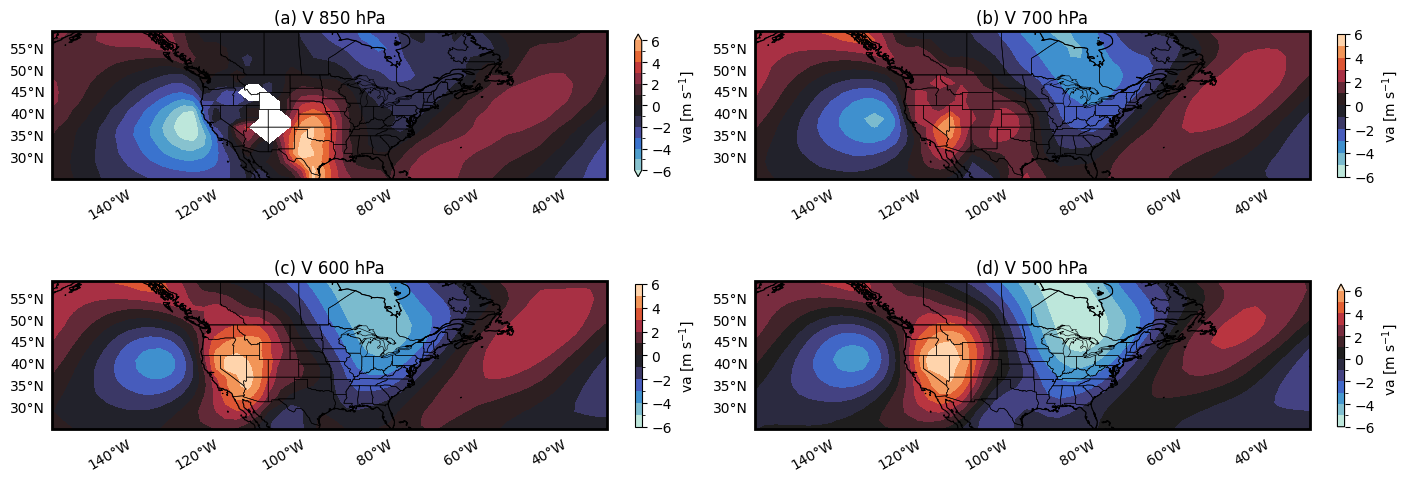

In [119]:
# ZONAL MEAN ANOMALY
fig, axes = plt.subplots(
    nrows=2, ncols=2, subplot_kw={'projection': ccrs.PlateCarree()},
    layout='constrained', figsize=(14, 5)
)
cbar_kwargs = {'label': r'va [m s$^{-1}$]', 'shrink': 0.6}
# +0K wind
for i, lev in enumerate(plev_subset.plev.values):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    da = ref.sel(plev=lev)
    zonal_mean = da.mean('lon')
    (da-zonal_mean).va.plot.contourf(ax=ax, vmin=-6, vmax=6, levels=13, cmap=cmap, transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs)
    # q = (da-zonal_mean).plot.quiver(
    #     ax=ax, x='lon', y='lat',
    #     u='ua',
    #     v='va',
    #     transform=ccrs.PlateCarree(), #scale=40
    # )
    # ref_magnitude = 10
    # ax.quiverkey(q, X=0.8, Y=1.05, U=ref_magnitude, label=f'{ref_magnitude}'+' m s$^{-1}$', labelpos='E')
    ax.set_title(f'({string.ascii_lowercase[i]}) V {int(lev/100)} hPa')

for ax in axes.flatten():
    add_latlon(ax)
    big_ax(ax)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.add_feature(cfeature.STATES, linewidth=0.4)
plt.show()

<>:23: SyntaxWarning: invalid escape sequence '\D'
<>:23: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_3616637/344070940.py:23: SyntaxWarning: invalid escape sequence '\D'
  ax.set_title(f'({string.ascii_lowercase[i]}) $\Delta$V {int(lev/100)} hPa')
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x1554c48e7590>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x15546b25bda0>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x15546b2ce540>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x15546b25bd70>


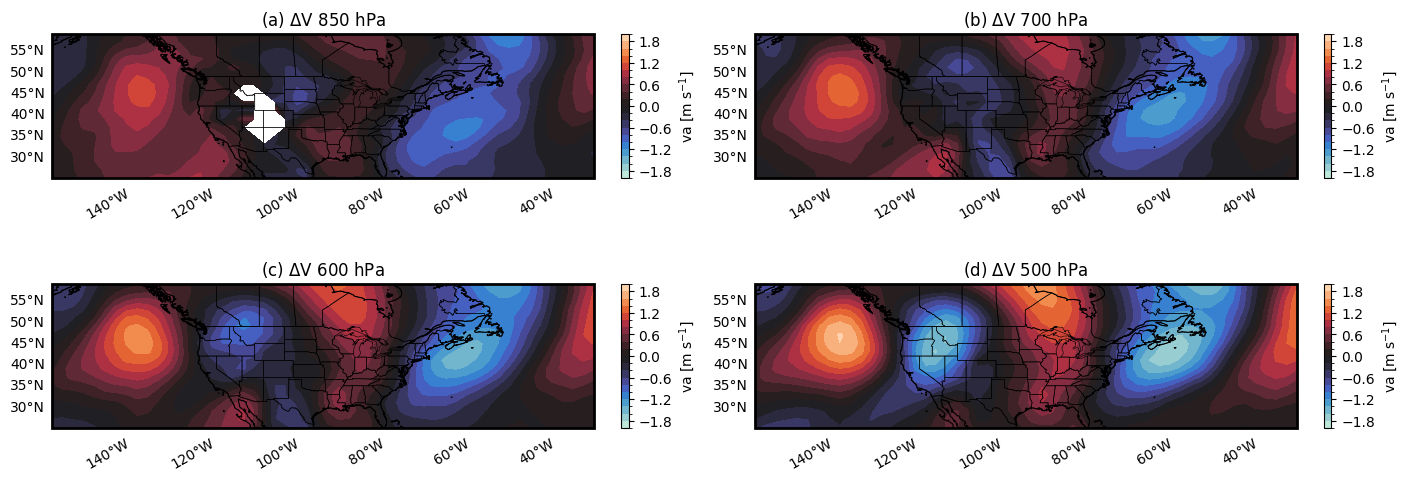

In [116]:
# ZONAL MEAN ANOMALY DIFFERENCE
fig, axes = plt.subplots(
    nrows=2, ncols=2, subplot_kw={'projection': ccrs.PlateCarree()},
    layout='constrained', figsize=(14, 5)
)
cbar_kwargs = {'label': r'va [m s$^{-1}$]', 'shrink': 0.6}
# +0K wind
for i, lev in enumerate(plev_subset.plev.values):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    da_ref = ref.sel(plev=lev) - ref.sel(plev=lev).mean('lon')
    da_perturb = perturb.sel(plev=lev) - perturb.sel(plev=lev).mean('lon')
    (da_perturb-da_ref).va.plot.contourf(ax=ax,vmin=-2, vmax=2, levels=21, cmap=cmap, transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs)
    # q = (da-zonal_mean).plot.quiver(
    #     ax=ax, x='lon', y='lat',
    #     u='ua',
    #     v='va',
    #     transform=ccrs.PlateCarree(), #scale=40
    # )
    # ref_magnitude = 10
    # ax.quiverkey(q, X=0.8, Y=1.05, U=ref_magnitude, label=f'{ref_magnitude}'+' m s$^{-1}$', labelpos='E')
    ax.set_title(f'({string.ascii_lowercase[i]}) $\Delta$V {int(lev/100)} hPa')

for ax in axes.flatten():
    add_latlon(ax)
    big_ax(ax)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.add_feature(cfeature.STATES, linewidth=0.4)
plt.show()

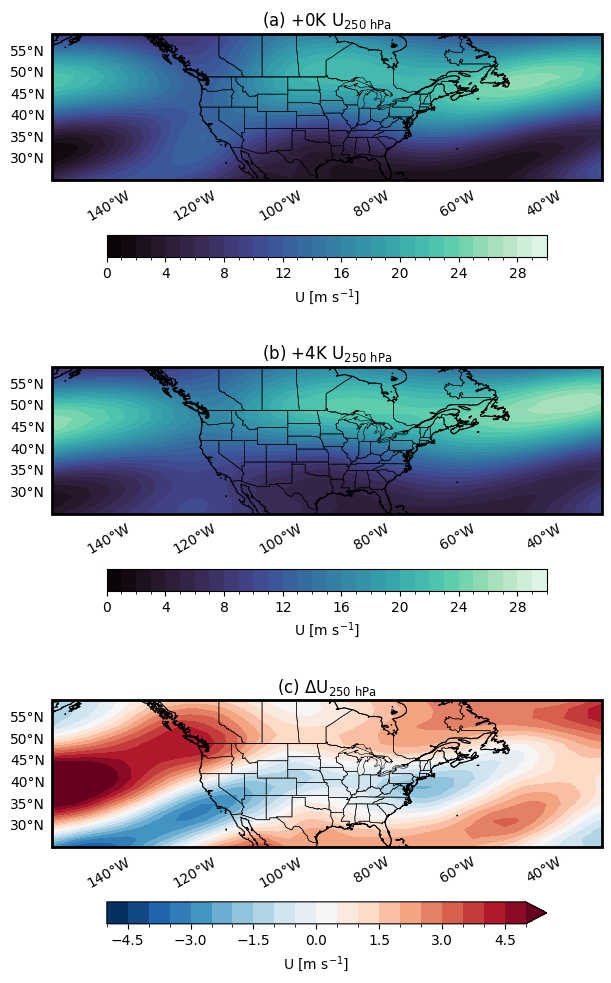

In [38]:
cmap = sns.color_palette("mako", as_cmap=True)

fig, axes = plt.subplots(
    nrows=3, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()},
    layout='constrained', figsize=(6, 10)
)
cbar_kwargs = {'label': 'U [m s$^{-1}$]', 'shrink': 0.8, 'orientation': 'horizontal'}
# +0K wind
ax = axes[0]
ref.sel(plev=250*100).ua.plot.contourf(ax=ax, levels=31, cmap=cmap, cbar_kwargs=cbar_kwargs, transform=ccrs.PlateCarree(), vmin=0, vmax=30)
ax.set_title(f'(a) +0K'+r' U$_{250\text{ hPa}}$')

# +4K wind
ax = axes[1]
perturb.sel(plev=250*100).ua.plot.contourf(ax=ax, levels=31, cmap=cmap, cbar_kwargs=cbar_kwargs, transform=ccrs.PlateCarree(), vmin=0, vmax=30)
ax.set_title(f'(b) +4K'+r' U$_{250\text{ hPa}}$')

# Diff wind
ax = axes[2]
diff.sel(plev=250*100).ua.plot.contourf(ax=ax, levels=21, cmap='RdBu_r', cbar_kwargs=cbar_kwargs, transform=ccrs.PlateCarree(), vmin=-5, vmax=5)
ax.set_title(r'(c) $\Delta$U$_{250\text{ hPa}}$')

for ax in axes:
    add_latlon(ax)
    big_ax(ax)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.add_feature(cfeature.STATES, linewidth=0.4)
plt.show()

### Jet position

In [92]:
rocky_mask = (ref.lon > -120+360) & (ref.lon < -90+360)

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x1554768f5af0>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x15546fa9b290>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x155476e87950>


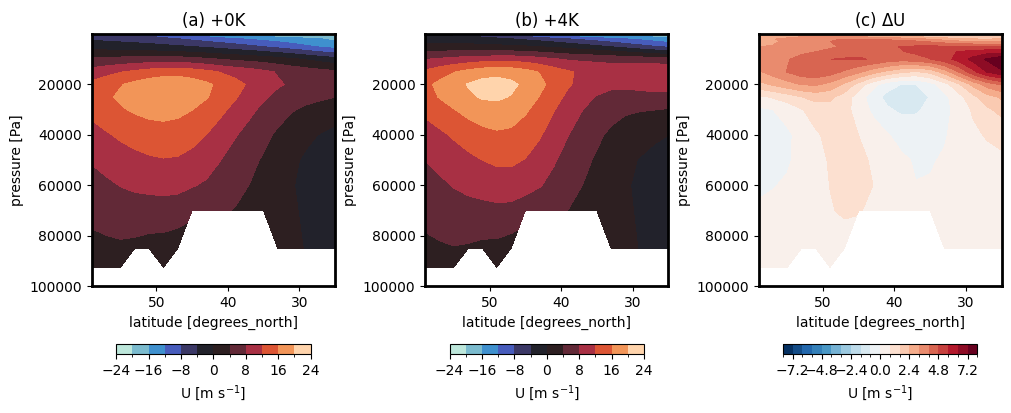

In [93]:
# zonal_mean = diff.mean('lon', skipna=False)
cmap = sns.color_palette("icefire", as_cmap=True)

fig, axes = plt.subplots(
    nrows=1, ncols=3,
    layout='constrained', figsize=(10, 4)
)
cbar_kwargs = {'label': 'U [m s$^{-1}$]', 'shrink': 0.8, 'orientation': 'horizontal'}
# +0K wind
ax = axes[0]
ref.where(rocky_mask, drop=True).mean('lon', skipna=False).ua.plot.contourf(ax=ax, levels=15, cmap=cmap, cbar_kwargs=cbar_kwargs)
ax.set_title(f'(a) +0K')

# +4K wind
ax = axes[1]
perturb.where(rocky_mask, drop=True).mean('lon', skipna=False).ua.plot.contourf(ax=ax, levels=15, cmap=cmap, cbar_kwargs=cbar_kwargs)
ax.set_title(f'(b) +4K')

# Diff wind
ax = axes[2]
diff.where(rocky_mask, drop=True).mean('lon', skipna=False).ua.plot.contourf(ax=ax, levels=21, cmap='RdBu_r', cbar_kwargs=cbar_kwargs)
ax.set_title(r'(c) $\Delta$U')

for ax in axes:
    big_ax(ax)
    ax.invert_xaxis()
    ax.invert_yaxis()
plt.show()

/home/valencig/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


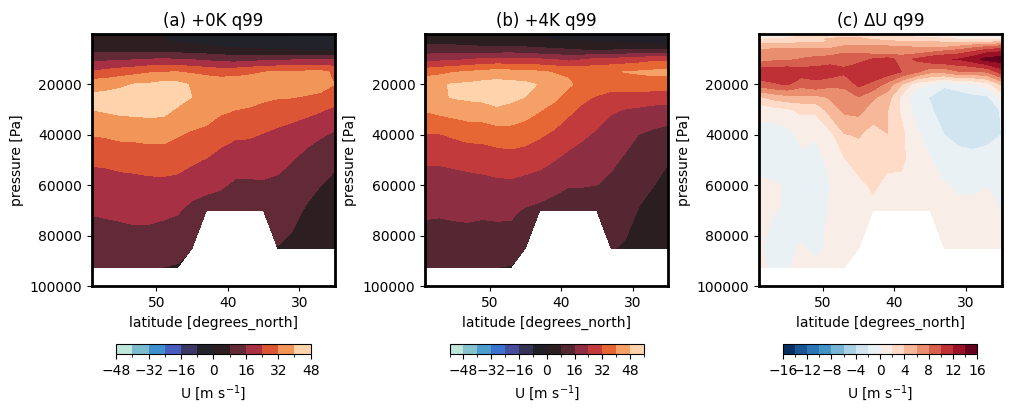

In [47]:
# zonal_mean = diff.mean('lon', skipna=False)
cmap = sns.color_palette("icefire", as_cmap=True)

fig, axes = plt.subplots(
    nrows=1, ncols=3,
    layout='constrained', figsize=(10, 4)
)
cbar_kwargs = {'label': 'U [m s$^{-1}$]', 'shrink': 0.8, 'orientation': 'horizontal'}

ref_99 = ds_conus.sel(forcing='+0K').ua.quantile(0.99, dim='time')
perturb_99 = ds_conus.sel(forcing='+4K').ua.quantile(0.99, dim='time')
diff_99 = perturb_99 - ref_99

# +0K wind
ax = axes[0]
ref_99.where(rocky_mask, drop=True).mean('lon', skipna=False).plot.contourf(ax=ax, levels=15, cmap=cmap, cbar_kwargs=cbar_kwargs)
ax.set_title(f'(a) +0K q99')

# +4K wind
ax = axes[1]
perturb_99.where(rocky_mask, drop=True).mean('lon', skipna=False).plot.contourf(ax=ax, levels=15, cmap=cmap, cbar_kwargs=cbar_kwargs)
ax.set_title(f'(b) +4K q99')

# Diff wind
ax = axes[2]
diff_99.where(rocky_mask, drop=True).mean('lon', skipna=False).plot.contourf(ax=ax, levels=21, cmap='RdBu_r', cbar_kwargs=cbar_kwargs)
ax.set_title(r'(c) $\Delta$U q99')

for ax in axes:
    big_ax(ax)
    ax.invert_xaxis()
    ax.invert_yaxis()
plt.show()

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x15546ba7fe30>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x15546fa04920>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x1554570f06b0>


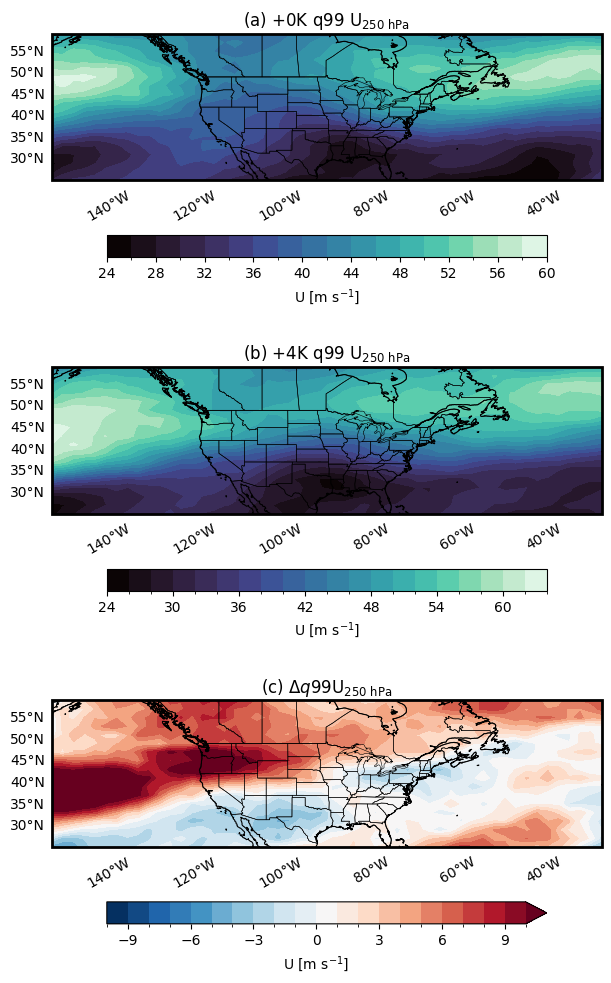

In [91]:
cmap = sns.color_palette("mako", as_cmap=True)

fig, axes = plt.subplots(
    nrows=3, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()},
    layout='constrained', figsize=(6, 10)
)
cbar_kwargs = {'label': 'U [m s$^{-1}$]', 'shrink': 0.8, 'orientation': 'horizontal'}
ref_99 = ds_conus.sel(forcing='+0K').sel(plev=250*100).ua.quantile(0.99, dim='time')
perturb_99 = ds_conus.sel(forcing='+4K').sel(plev=250*100).ua.quantile(0.99, dim='time')
diff_99 = perturb_99 - ref_99
# +0K wind
ax = axes[0]
ref_99.plot.contourf(ax=ax, levels=21, cmap=cmap, cbar_kwargs=cbar_kwargs, transform=ccrs.PlateCarree())
ax.set_title(f'(a) +0K q99'+r' U$_{250\text{ hPa}}$')

# +4K wind
ax = axes[1]
perturb_99.plot.contourf(ax=ax, levels=21, cmap=cmap, cbar_kwargs=cbar_kwargs, transform=ccrs.PlateCarree())
ax.set_title(f'(b) +4K q99'+r' U$_{250\text{ hPa}}$')

# Diff wind
ax = axes[2]
diff_99.plot.contourf(ax=ax, levels=21, cmap='RdBu_r', cbar_kwargs=cbar_kwargs, transform=ccrs.PlateCarree(), vmin=-10, vmax=10)
ax.set_title(r'(c) $\Delta q99 $U$_{250\text{ hPa}}$')

for ax in axes:
    add_latlon(ax)
    big_ax(ax)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.add_feature(cfeature.STATES, linewidth=0.4)
plt.show()

## Meridional Momentum

(spring intensification, see Zhou et al.)

$$\left[\frac{\bar{u}}{a \cos \vartheta}\frac{\partial \bar{v}}{\partial \lambda} + \frac{\bar{v}}{a}\frac{\partial \bar{v}}{\partial \vartheta}+\bar{\omega}\frac{\partial \bar{v}}{\partial p}+f\bar{u}+\frac{\bar{u}\bar{u}}{a}\tan\vartheta+\frac{1}{a}\frac{\partial \overline{\Phi}}{\partial \vartheta}\right]_{\text{mean}}
    + \left[\overline{\frac{u'}{a\cos\vartheta}\frac{\partial v'}{\partial \lambda}}^t+\overline{\frac{v'}{a}\frac{\partial v'}{\partial \vartheta}}^t+\overline{\omega'\frac{\partial v'}{\partial p}}^t+\overline{\frac{u'u'}{a}\tan\vartheta}^t\right]_{\text{eddy}}=0$$

Note: $\frac{\partial}{\partial x} = \frac{1}{a\cos\vartheta}\frac{\partial}{\partial \lambda}$ and $\frac{\partial}{\partial y}=\frac{1}{a}\frac{\partial}{\partial y}$

Also note that for the zonal winds, $f\bar{v} \to -f\bar{u}$. Some other terms change as well. See page 68 in Vallis (2017).

### Function for derivatives
For the vertical derivative we have the following from the hydrostatic approximation:
$$\frac{\partial u}{\partial z}= -\rho g \frac{\partial u}{\partial p}$$ 
The units are 
$$=\frac{kg}{m^3}\frac{m}{s^2}\frac{m}{s}\frac{1}{Pa}=\frac{kg}{m^3}\frac{m}{s^2}\frac{m}{s}\frac{m s^2}{kg}=\frac{1}{s}$$


In [24]:
def compute_derivatives(ds):
    """
    Compute necessary derivatives using Metpy.

    Parameters:
    ds (xarray.Dataset): Input dataset containing ['ua', 'va', 'Phi']

    Returns:
    xarray.Dataset: Dataset containing various derivatives.
    """
    
    # Compute zonal and meridional derivatives
    # dudx, dudy, dvdx, dvdy = mpcalc.vector_derivative(ds.ua, ds.va, longitude=ds.lon, latitude=ds.lat)

    dudx = mpcalc.first_derivative(ds.ua, axis='lon')
    dudy = mpcalc.first_derivative(ds.ua, axis='lat')
    dvdx = mpcalc.first_derivative(ds.va, axis='lon')
    dvdy = mpcalc.first_derivative(ds.va, axis='lat')
    
    # Compute vertical derivatives 
    dudp = mpcalc.first_derivative(ds.ua, axis='plev')
    dvdp = mpcalc.first_derivative(ds.va, axis='plev')

    # Compute geopotential derivatives
    Phi_dudx = mpcalc.first_derivative(ds.Phi, axis='lon')
    Phi_dudy = mpcalc.first_derivative(ds.Phi, axis='lat')

    # Save as one dataset
    def _make_da(arr, ds):
        try:
            units = str(arr.units)
        except:
            units = str(arr.metpy.units)
        da = xr.DataArray(
            data=arr,
            dims=ds.ua.dims,
            coords=ds.coords,
            attrs={"units": units}
        )
        return da
    # Create a new dataset with the derivatives
    derivatives_ds = xr.Dataset({
        'dudx': _make_da(dudx, ds),
        'dudy': _make_da(dudy, ds),
        'dvdx': _make_da(dvdx, ds),
        'dvdy': _make_da(dvdy, ds),
        'dudp': _make_da(dudp, ds),
        'dvdp': _make_da(dvdp, ds),
        'Phi_dudx': _make_da(Phi_dudx, ds),
        'Phi_dudy': _make_da(Phi_dudy, ds),
    })
    for name, da in derivatives_ds.items():
        if name == 'Phi_dudx' or name == 'Phi_dudy':
            assert da.metpy.units == units('m s^-2')
        elif name == 'dudp' or name == 'dvdp':
            assert da.metpy.units == units('m s^-1 Pa^-1')
        else:
            assert da.metpy.units == units('s^-1')
        
    return derivatives_ds

### Get terms

In [25]:
def get_meridional_terms(ds):# Get mean state and eddy terms
    mean_vals = ds.mean('time')
    eddy_vals = ds - mean_vals
    mean = compute_derivatives(mean_vals)
    eddy = compute_derivatives(eddy_vals)
    # Terms
    u_bar = mean_vals.ua
    v_bar = mean_vals.va
    omega_bar = mean_vals.wap
    u_prime = eddy_vals.ua
    v_prime = eddy_vals.va
    omega_prime = eddy_vals.wap
    x_lambda = np.deg2rad(ds.lon) # lambda
    y_theta = np.deg2rad(ds.lat) # theta
    OMEGA = mpconst.earth_avg_angular_vel.to('s^-1') # Angular velocity of the earth
    a = mpconst.earth_avg_radius # Radius of the earth
    f = 2*OMEGA*np.sin(y_theta)
    
    # New terms
    # vu_x = mpcalc.first_derivative((v_prime*u_prime).mean('time'), axis='lon')
    # vv_y = mpcalc.first_derivative((v_prime*v_prime).mean('time'), axis='lat')
    # vomega_p = mpcalc.first_derivative((v_prime*omega_prime).mean('time'), axis='plev')
    
    # Now create terms
    terms = {
        r'$\overline{u}\frac{\partial \overline{v}}{\partial x}$': u_bar * mean.dvdx,
        r'$\overline{v}\frac{\partial \overline{v}}{\partial y}$': v_bar * mean.dvdy,
        r'$\overline{\omega}\frac{\partial \overline{v}}{\partial p}$': omega_bar * mean.dvdp,
        r'$f\overline{u}$': f * u_bar,
        r'$\frac{\overline{u}\overline{u}}{a}\tan{\vartheta}$': (u_bar*u_bar)/a * np.tan(y_theta),
        r'$\frac{\partial \overline{\Phi}}{\partial y}$': mean.Phi_dudy,
        r"$\overline{u'\frac{\partial v'}{\partial x}}^t$": (u_prime * eddy.dvdx).mean('time'),
        r"$\overline{v'\frac{\partial v'}{\partial y}}^t$": (v_prime * eddy.dvdy).mean('time'),
        r"$\overline{\omega'\frac{\partial v'}{\partial p}}^t$": (omega_prime * mean.dvdp).mean('time'),
        r"$\overline{\frac{u'u'}{a}\tan{\vartheta}}^t$": ((u_prime * u_prime)/a * np.tan(y_theta)).mean('time'),

        # New way of doing it??
        # r"$\overline{u'\frac{\partial v'}{\partial x}}^t$": vu_x,
        # r"$\overline{v'\frac{\partial v'}{\partial y}}^t$": vv_y,
        # r"$\overline{\omega'\frac{\partial v'}{\partial p}}^t$": vomega_p,
    }
    # Convert all terms to daily
    return_dict = {}
    for key, term in terms.items():
        return_dict[key] = term * 60 * 60 * 24 * units('day^-1')
    return return_dict
    
terms = {
        r'$\overline{u}\frac{\partial \overline{v}}{\partial x}$': [],
        r'$\overline{v}\frac{\partial \overline{v}}{\partial y}$': [],
        r'$\overline{\omega}\frac{\partial \overline{v}}{\partial p}$': [],
        r'$f\overline{u}$': [],
        r'$\frac{\overline{u}\overline{u}}{a}\tan{\vartheta}$': [],
        r'$\frac{\partial \overline{\Phi}}{\partial y}$': [],
        r"$\overline{u'\frac{\partial v'}{\partial x}}^t$": [],
        r"$\overline{v'\frac{\partial v'}{\partial y}}^t$": [],
        r"$\overline{\omega'\frac{\partial v'}{\partial p}}^t$": [],
        r"$\overline{\frac{u'u'}{a}\tan{\vartheta}}^t$": [],
    }

from tqdm import tqdm 
for year in tqdm(range(1979, 2015)): 
# for year in tqdm(range(1990, 2000)):### CHANGE THIS LATER ###########################
    subset = (
        ds
        .sel(time=slice(f'{year}-01-01', f'{year}-12-31')) # 1 year chunks
        # .sel(plev=[100000.,  70000.,  50000., 25000.]) # Can't filter by plev or derivatives are messed up
        .compute()
    )
    meridional_terms = get_meridional_terms(subset)
    for key, da in meridional_terms.items():
        terms[key].append(da)

x_ticks = np.arange(1979, 2015) # [1979, 2014]
flattened = []
for key, das in terms.items():
    renamed = [da.rename(key) for da in das]
    # Need to add time in
    for year, da in zip(x_ticks, renamed):
        flattened.append(da.expand_dims(dim={'time': [int(year)]}))
ds_terms_meridional = xr.merge(flattened).compute().transpose('forcing', 'time', 'plev', 'lat', 'lon')

# meridional_terms = get_meridional_terms(ds_conus)

residual = 0
for key in list(ds_terms_meridional.keys()):
    residual += ds_terms_meridional[key]
ds_terms_meridional['residual'] = residual 

100%|██████████| 36/36 [04:29<00:00,  7.50s/it]


In [26]:
# Now get difference
meridional_mean_state = ds_terms_meridional.mean('time')
diff = meridional_mean_state.sel(forcing='+4K') - meridional_mean_state.sel(forcing='+0K')

### Magnitude of terms

In [28]:
adv_terms = [
    r'$\overline{u}\frac{\partial \overline{v}}{\partial x}$',
    r'$\overline{v}\frac{\partial \overline{v}}{\partial y}$',
    r'$\overline{\omega}\frac{\partial \overline{v}}{\partial p}$'
]
adv = 0
for k in adv_terms:
    adv += ds_terms_meridional[k]

eddy_terms = [
    r"$\overline{u'\frac{\partial v'}{\partial x}}^t$",
    r"$\overline{v'\frac{\partial v'}{\partial y}}^t$",
    r"$\overline{\omega'\frac{\partial v'}{\partial p}}^t$",
]
eddy = 0
for k in eddy_terms:
    eddy += ds_terms_meridional[k]

In [33]:
def rms_term(term):
    return np.sqrt((term**2).mean()).values
    # return np.abs(term).mean().values
    
hPa200 = {'plev': 200*100, 'forcing': '+0K'}
print('200 hPa')
print('Coriolis', rms_term(ds_terms_meridional[r'$f\overline{u}$'].sel(hPa200)))
print('Pressure Gradient', rms_term(ds_terms_meridional[r'$\frac{\partial \overline{\Phi}}{\partial y}$'].sel(hPa200)))
print('Mean advection', rms_term(adv.sel(hPa200)))
print('Eddy advection', rms_term(eddy.sel(hPa200)))
print('Residual', rms_term(residual.sel(hPa200)))

print('\n\n925 hPa (ABL)')
hPa925 = {'plev': 925*100, 'forcing': '+0K'}
print('Coriolis', rms_term(ds_terms_meridional[r'$f\overline{u}$'].sel(hPa925)))
print('Pressure Gradient', rms_term(ds_terms_meridional[r'$\frac{\partial \overline{\Phi}}{\partial y}$'].sel(hPa925)))
print('Mean advection', rms_term(adv.sel(hPa925)))
print('Eddy advection', rms_term(eddy.sel(hPa925)))
print('Residual', rms_term(residual.sel(hPa925)))

200 hPa

Coriolis 138.6274378621088

Pressure Gradient 141.45434278736312

Mean advection 4.5482182851224096

Eddy advection 6.9494725196978475

Residual 2.7987412349155028

925 hPa (ABL)

Coriolis 29.579006968653022

Pressure Gradient 45.20511557453839

Mean advection 0.8235373859765869

Eddy advection 1.9650693493630662

Residual 16.902088823615642

In [ ]:
# Determine statistical signifigance using two sided students t-test
# from scipy.stats import ttest_ind
# ref = ds_terms_meridional.sel(forcing='+0K')
# perturb = ds_terms_meridional.sel(forcing='+4K')

# das = []
# for key in tqdm(list(ds_terms_meridional.keys())): 
#     # Perform t-test along the time dimension
#     t_stat, p_value = ttest_ind(ref[key], perturb[key], axis=0) # time is first dimension
#     np.shape(t_stat)
#     p_val_da = xr.DataArray(p_value, coords=[ref.plev, ref.lat, ref.lon], dims=['plev', 'lat', 'lon']).rename(key)
#     das.append(p_val_da)
# ds_pval = xr.merge(das)

### Plots

In [47]:
lev = 925

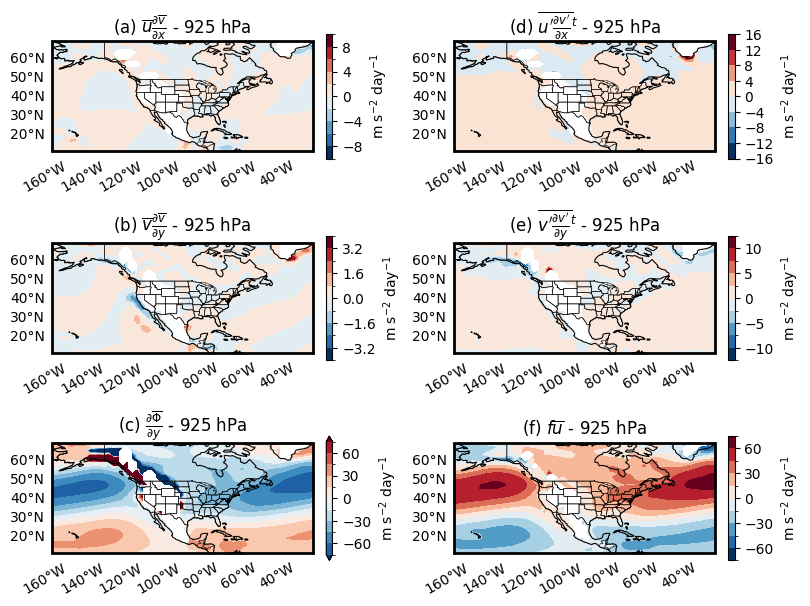

In [50]:
mean_keys = [
    '$\\overline{u}\\frac{\\partial \\overline{v}}{\\partial x}$',
    '$\\overline{v}\\frac{\\partial \\overline{v}}{\\partial y}$',
    '$\\frac{\\partial \\overline{\\Phi}}{\\partial y}$',
]
# One mean term in here
eddy_keys = [
    "$\\overline{u'\\frac{\\partial v'}{\\partial x}}^t$",
     "$\\overline{v'\\frac{\\partial v'}{\\partial y}}^t$",
    r'$f\overline{u}$', # Not an eddy term but needed it for plotting
]
fig, axes = plt.subplots(
    ncols=2, nrows=3,
    figsize=(8, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}, layout='constrained'
    )
cbar_kwargs = {'orientation':'vertical', 'shrink':0.8, 'label': r'm s$^{-2}$ day$^{-1}$'}#, 'format':'%.0e'}
plot_kwargs = {'cmap': 'RdBu_r'}#, 'vmin': -3, 'vmax': 3,} 
# Plot mean
for ax, key, label in zip(axes[:, 0], mean_keys, ['a', 'b', 'c']):
    if key == '$\\frac{\\partial \\overline{\\Phi}}{\\partial y}$':
        meridional_mean_state.sel(forcing='+0K')[key].sel(plev=lev*100).plot.contourf(ax=ax, vmax=75, levels=11, cbar_kwargs=cbar_kwargs, **plot_kwargs)
    else:
        meridional_mean_state.sel(forcing='+0K')[key].sel(plev=lev*100).plot.contourf(ax=ax, levels=11, cbar_kwargs=cbar_kwargs, **plot_kwargs)
    add_latlon(ax)
    big_ax(ax)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.add_feature(cfeature.STATES, linewidth=0.4)
    ax.set_title(f'({label}) '+key+f' - {lev} hPa')
    
# Plot eddy
for ax, key, label in zip(axes[:, 1], eddy_keys, ['d', 'e', 'f']):
    meridional_mean_state.sel(forcing='+0K')[key].sel(plev=lev*100).plot.contourf(ax=ax, levels=11, cbar_kwargs=cbar_kwargs, **plot_kwargs)
    add_latlon(ax)
    big_ax(ax)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.add_feature(cfeature.STATES, linewidth=0.4)
    ax.set_title(f'({label}) '+key+f' - {lev} hPa')
    
plt.show()

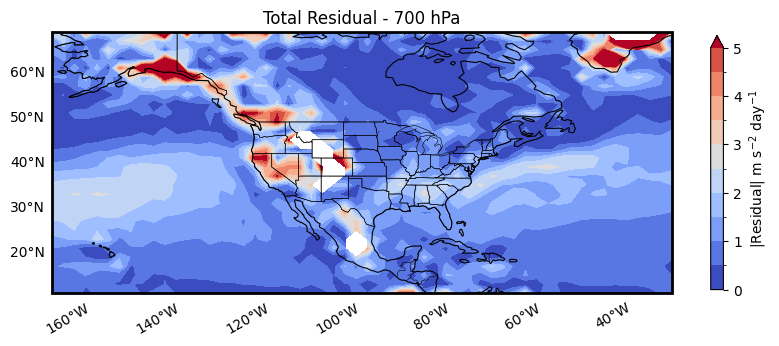

Mean Residual Value 1.2335073993874668

In [228]:
### Plot residual
fig, ax = plt.subplots(
    # ncols=2, nrows=3,
    figsize=(10, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}
)
mean_residual = (meridional_mean_state.sel(forcing='+0K', plev=lev*100)['residual'])
np.abs(mean_residual).plot.contourf(
    ax=ax, 
    vmin=0, vmax=5,
    cmap='coolwarm',#sns.color_palette("rocket", as_cmap=True), 
    cbar_kwargs={'orientation':'vertical', 'shrink':0.55, 'label': r'|Residual| m s$^{-2}$ day$^{-1}$'},
    levels=11
)
add_latlon(ax)
big_ax(ax)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
ax.add_feature(cfeature.STATES, linewidth=0.4)
ax.set_title(f'Total Residual - {lev} hPa')
plt.show()
print('Mean Residual Value', np.abs(mean_residual).mean().values)

See if the residual is due to the viscous term $\nu \nabla^2 \vec{v}$

No: the laplacian is tiny

In [ ]:
mean_v = ds.va
la = mpcalc.laplacian(mean_v, axes=['lat', 'lon'])
# Kinematic viscosity has units m^2/s, using 5500 m
# https://www.engineeringtoolbox.com/international-standard-atmosphere-d_985.html
viscous = ((2.3 * 10**-5 * units('m^2 s^-1')* la)* 60 * 60 * 24 * units('day^-1')).mean('time').sel(forcing='+0K', plev=500*100)
residual_diff = (mean_residual - viscous)
print('Mean Residual Value', residual_diff.mean().values)

### Ratio of terms to residual

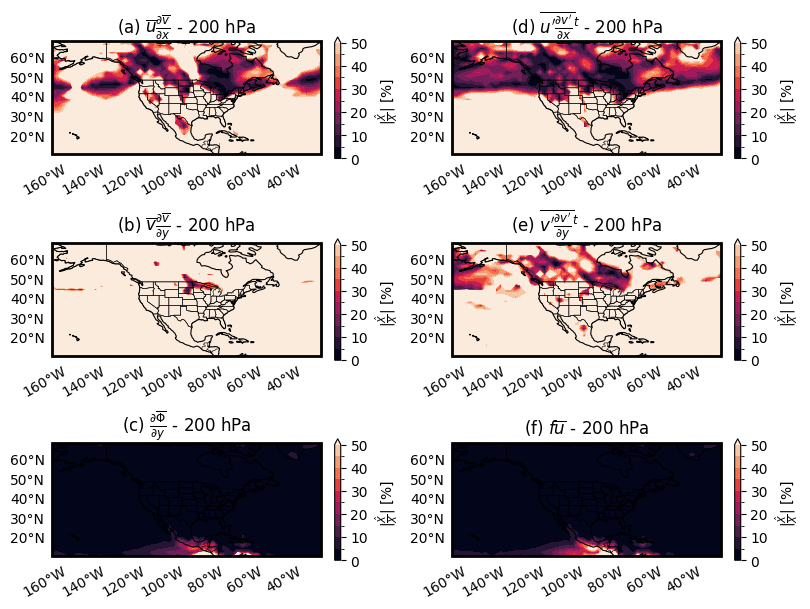

In [225]:
mean_keys = [
    '$\\overline{u}\\frac{\\partial \\overline{v}}{\\partial x}$',
    '$\\overline{v}\\frac{\\partial \\overline{v}}{\\partial y}$',
    '$\\frac{\\partial \\overline{\\Phi}}{\\partial y}$',
]
# One mean term in here
eddy_keys = [
    "$\\overline{u'\\frac{\\partial v'}{\\partial x}}^t$",
     "$\\overline{v'\\frac{\\partial v'}{\\partial y}}^t$",
    r'$f\overline{u}$',
]
fig, axes = plt.subplots(
    ncols=2, nrows=3,
    figsize=(8, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}, layout='constrained'
    )
cbar_kwargs = {'orientation':'vertical', 'shrink':0.8, 'label': r'|$\frac{\hat{X}}{X}$| [%]'}#, 'format':'%.0e'}
cmap = sns.color_palette("rocket", as_cmap=True)
plot_kwargs = {'cmap': cmap, 'vmin': 0, 'vmax': 50,} 
# Plot mean
for ax, key, label in zip(axes[:, 0], mean_keys, ['a', 'b', 'c']):

    ratio = np.abs(mean_residual/meridional_mean_state).sel(forcing='+0K')[key].sel(plev=lev*100) * 100
    # if label == 'c': # Set new vmin and vmax
    #     ratio.plot.contourf(ax=ax, levels=11, vmin=0, vmax=100, cbar_kwargs=cbar_kwargs, cmap=cmap)
    # else:
    ratio.plot.contourf(ax=ax, levels=11, cbar_kwargs=cbar_kwargs, **plot_kwargs)
    add_latlon(ax)
    big_ax(ax)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.add_feature(cfeature.STATES, linewidth=0.4)
    ax.set_title(f'({label}) '+key+f' - {lev} hPa')
    
# Plot eddy
for ax, key, label in zip(axes[:, 1], eddy_keys, ['d', 'e', 'f']):
    ratio = np.abs(mean_residual/meridional_mean_state.sel(forcing='+0K')[key].sel(plev=lev*100)) * 100
    # if label == 'f': # Set new vmin and vmax
    #     ratio.plot.contourf(ax=ax, levels=11, vmin=0, vmax=100, cbar_kwargs=cbar_kwargs, cmap=cmap)
    # else:
    ratio.plot.contourf(ax=ax, levels=11, cbar_kwargs=cbar_kwargs, **plot_kwargs)
    add_latlon(ax)
    big_ax(ax)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.add_feature(cfeature.STATES, linewidth=0.4)
    ax.set_title(f'({label}) '+key+f' - {lev} hPa')
plt.show()

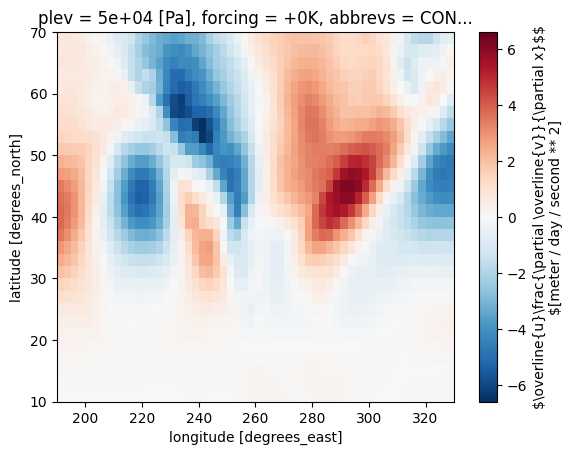

In [185]:
foo = meridional_mean_state[r'$\overline{u}\frac{\partial \overline{v}}{\partial x}$']
foo.sel(forcing='+0K', plev=lev*100).plot()

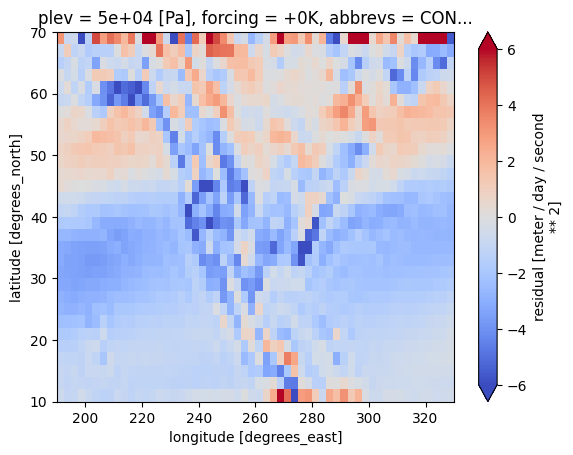

In [186]:
bar = meridional_mean_state.sel(forcing='+0K', plev=lev*100)['residual']
bar.plot(vmax=6, vmin=-6, cmap='coolwarm')

All advective terms

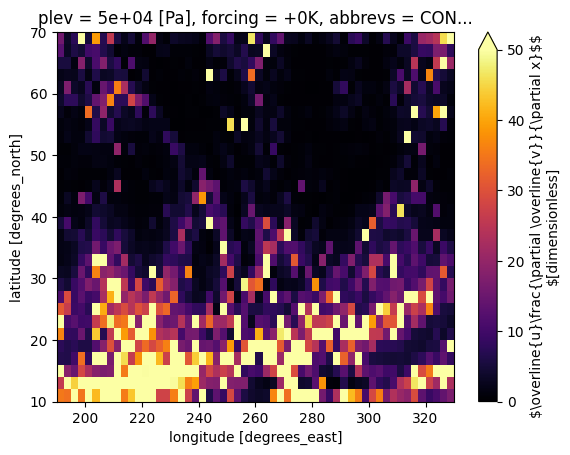

In [158]:
adv_terms = [
    r'$\overline{u}\frac{\partial \overline{v}}{\partial x}$',
    r'$\overline{v}\frac{\partial \overline{v}}{\partial y}$',
    r'$\overline{\omega}\frac{\partial \overline{v}}{\partial p}$'
]
adv = 0
for k in adv_terms:
    adv += ds_terms_meridional[k]
# Have in 10^4 to be the same as "Zonal Momentum Balance in the Tropical Atmospheric Circulation during the Global Monsoon Mature Months"
np.abs(residual/adv).mean('time').sel(plev=lev*100, forcing='+0K').plot(vmin=0, vmax=50, cmap='inferno')

## Try to close budget without decomposition

$$\left(\frac{\partial v}{\partial t}+\frac{u}{a\cos\vartheta}\frac{\partial v}{\partial\lambda}+\frac{v}{a}\frac{\partial v}{\partial\vartheta}+\omega\frac{\partial v}{\partial p}\right) + fu+\frac{uu}{a}\tan\vartheta = -\frac{1}{a}\frac{\partial \Phi}{\partial \vartheta}$$
Get every term at every point in time

In [ ]:
test_ds = ds.sel(time=slice('2000-01-01', '2005-12-31')).compute()

In [47]:
def compute_derivatives_full(ds):
    """
    Compute necessary derivatives using Metpy.

    Parameters:
    ds (xarray.Dataset): Input dataset containing ['ua', 'va', 'Phi']

    Returns:
    xarray.Dataset: Dataset containing various derivatives.
    """
    
    # Compute zonal and meridional derivatives
    dudx, dudy, dvdx, dvdy = mpcalc.vector_derivative(ds.ua, ds.va, longitude=ds.lon, latitude=ds.lat)
    
    # Compute vertical derivatives 
    dudp = mpcalc.first_derivative(ds.ua, axis='plev')
    dvdp = mpcalc.first_derivative(ds.va, axis='plev')

    # Compute geopotential derivatives
    Phi_dudx = mpcalc.first_derivative(ds.Phi, axis='lon')
    Phi_dudy = mpcalc.first_derivative(ds.Phi, axis='lat')

    # Compute time derivatives
    u_dt = mpcalc.first_derivative(ds.ua, axis='time')
    v_dt = mpcalc.first_derivative(ds.va, axis='time')

    # Save as one dataset
    def _make_da(arr, ds):
        try:
            units = str(arr.units)
        except:
            units = str(arr.metpy.units)
        da = xr.DataArray(
            data=arr,
            dims=ds.ua.dims,
            coords=ds.coords,
            attrs={"units": units}
        )
        return da
    # Create a new dataset with the derivatives
    derivatives_ds = xr.Dataset({
        'dudx': _make_da(dudx, ds),
        'dudy': _make_da(dudy, ds),
        'dvdx': _make_da(dvdx, ds),
        'dvdy': _make_da(dvdy, ds),
        'dudp': _make_da(dudp, ds),
        'dvdp': _make_da(dvdp, ds),
        'Phi_dudx': _make_da(Phi_dudx, ds),
        'Phi_dudy': _make_da(Phi_dudy, ds),
        'u_dt': _make_da(u_dt, ds),
        'v_dt': _make_da(v_dt, ds),
    })
    for name, da in derivatives_ds.items():
        if name == 'Phi_dudx' or name == 'Phi_dudy':
            assert da.metpy.units == units('m s^-2')
        elif name == 'dudp' or name == 'dvdp':
            assert da.metpy.units == units('m s^-1 Pa^-1')
        elif name == 'u_dt' or name == 'v_dt':
            assert da.metpy.units == units('m s^-2')
        else:
            assert da.metpy.units == units('s^-1')
        
    return derivatives_ds
    
def get_meridional_terms(ds):# Get mean state and eddy terms
    derivatives = compute_derivatives_full(ds)
    x_lambda = np.deg2rad(ds.lon) # lambda
    y_theta = np.deg2rad(ds.lat) # theta
    OMEGA = mpconst.earth_avg_angular_vel.to('s^-1') # Angular velocity of the earth
    a = mpconst.earth_avg_radius # Radius of the earth
    f = 2*OMEGA*np.sin(y_theta)
    # Now create terms
    terms = {
        r'$\frac{\partial v}{\partial t}$': derivatives.v_dt,
        r'$u\frac{\partial v}{\partial x}$': ds.ua * derivatives.dvdx,
        r'$v\frac{\partial v}{\partial y}$': ds.va * derivatives.dvdy,
        r'$\omega\frac{\partial v}{\partial p}$': ds.wap * derivatives.dvdp,
        r'$fu$': f * ds.ua,
        r'$\frac{uu}{a}\tan{\vartheta}$': (ds.ua*ds.ua)/a * np.tan(y_theta),
        r'$\frac{\partial \Phi}{\partial y}$': derivatives.Phi_dudy,
    }
    # Convert all terms to daily and get mean
    return_list = []
    for key, term in terms.items():
        return_list.append(term.rename(key) * 60 * 60 * 24 * units('day^-1'))
    # return return_list
    return xr.merge(return_list).transpose('forcing', 'time', 'plev', 'lat', 'lon').compute()
    
full_terms = get_meridional_terms(test_ds)
residual = 0
for key in list(full_terms.keys()):
    residual += full_terms[key]
full_terms['residual'] = residual 
full_terms

<xarray.Dataset> Size: 9GB
Dimensions:                                (lat: 30, lon: 56, plev: 19,
                                            time: 2190, forcing: 2)
Coordinates:
  * lat                                    (lat) float64 240B 11.0 13.0 ... 69.0
  * lon                                    (lon) float64 448B 191.2 ... 328.8
  * plev                                   (plev) float64 152B 1e+05 ... 100.0
  * time                                   (time) object 18kB 2000-01-01 12:0...
  * forcing                                (forcing) <U3 24B '+0K' '+4K'
    abbrevs                                <U5 20B 'CONUS'
    names                                  <U25 100B 'Continental United States'
    metpy_crs                              object 8B Projection: latitude_lon...
Data variables:
    $\frac{\partial v}{\partial t}$        (forcing, time, plev, lat, lon) float64 1GB <Quantity([[[[[-7.04841018e-01 -1.51089627e+00 -1.71613991e+00 ...      -1.04578900e+00 -8.35951805e-01 -5.33741236e-01]     [ 2.74890482e-01 -1.59482354e+00 -2.27846906e+00 ...      -5.24516821e-01 -1.78812313e+00 -2.00318170e+00]     [-7.36647099e-01 -1.34783620e+00 -2.22429872e+00 ...      -3.17879677e-01 -1.30456662e+00 -1.36927915e+00]     ...     [-5.61517811e+00  3.13920355e+00  6.97648573e+00 ...                  nan             nan             nan]     [-7.45033169e+00 -2.15863967e+00  7.87418842e-01 ...                  nan             nan             nan]     [-6.55118966e+00 -6.80437195e+00 -5.19738615e+00 ...                  nan             nan             nan]]     [[-3.30195695e-01 -4.77603367e-01 -5.69974452e-01 ...      -1.49031067e+00 -6.08964920e-01 -6.72752857e-02]     [ 6.00631058e-01 -4.13200200e-01 -6.93984687e-01 ...      -4.77171183e-01 -1.71663499e+00 -7.20286131e-01]     [-1.10640287e+00 -3.18621099e-01 -9.76940110e-01 ...      -5.60904503e-01 -1.51173925e+00 -1.36946964e+00]     ...     [-5.48042822e+00  1.86685514e+00  5.95281172e+00 ...      -3.84907198e+00  4.14391100e-01  3.87517858e+00]     [-6.51985812e+00 -2.88917589e+00  1.60547876e+00 ...      -7.76912403e+00 -2.99916887e+00  2.91666555e+00]     [-6.17431378e+00 -8.23834240e+00 -4.83669400e+00 ...                  nan  9.36227918e-01  2.90516865e+00]]     [[-2.83072978e+00 -9.53524917e-01 -5.78271873e-01 ...      -2.82459592e+00 -9.73422855e-01 -3.09535027e+00]     [-3.05260873e+00 -1.49007684e+00 -1.96396527e+00 ...       1.40365991e+00  3.50609925e+00 -2.74870262e-01]     [-3.01167834e+00 -3.32392579e+00 -4.96500707e+00 ...       1.35012975e+00  1.15373844e+00  1.16110590e+00]     ...     [-4.32589817e+00  3.20709276e+00  8.60514879e+00 ...       8.92717838e-02  3.24951768e+00  6.00528622e+00]     [-5.09763575e+00 -1.63793421e+00  2.82602692e+00 ...      -5.08141402e-01  2.19843143e+00  4.24807349e+00]     [-3.69031978e+00 -5.98711586e+00 -2.93277836e+00 ...                  nan  1.01389980e+00  2.58298600e+00]]     ...     [[-1.53649849e+00 -1.92454380e+00 -2.34190530e+00 ...       3.21213706e+00  3.70134935e+00  4.35554841e+00]     [-1.68470633e+00 -2.46603370e+00 -3.00683385e+00 ...       2.42321764e+00  2.62561912e+00  2.96995004e+00]     [-1.91709691e+00 -3.04744294e+00 -3.90825397e+00 ...       1.86121494e+00  1.96079963e+00  2.23472428e+00]     ...     [-1.17828214e+00 -3.33198461e+00 -5.81773888e+00 ...       3.96749753e+00  3.55216680e+00  2.92962801e+00]     [-9.99168932e-01 -2.03244019e+00 -3.23529428e+00 ...       3.17998958e+00  2.69455075e+00  1.95522954e+00]     [-1.03543657e+00 -1.75386007e+00 -2.60126835e+00 ...       2.21294671e+00  1.54898632e+00  6.58139527e-01]]     [[-8.88862684e-01 -4.06555653e-01 -2.73469865e-01 ...       8.04477662e-01  1.66006178e+00  2.66095904e+00]     [-1.93452457e+00 -1.56314307e+00 -1.09919864e+00 ...       7.94833839e-01  1.31834698e+00  1.83711094e+00]     [-2.24703549e+00 -1.94764257e+00 -1.71604842e+00 ...       1.52402556e+00  1.56310686e+00  1.64859366e+00]     ...     [-6.63351420e+00 -8.63238928e+00 -1.0

In [48]:
time_mean = full_terms.mean('time')

Assert that $\frac{\partial u}{\partial v}$ is 0

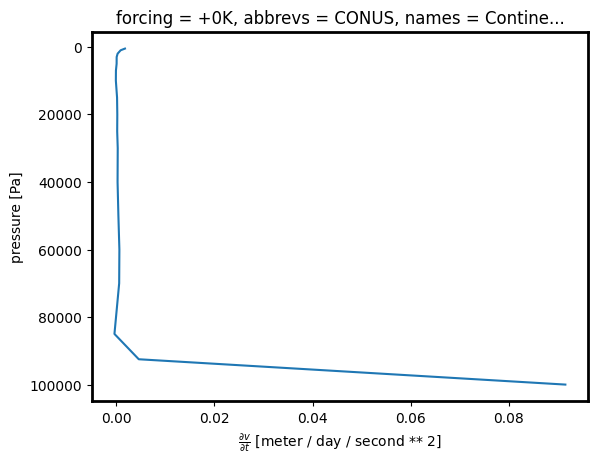

In [49]:
fig, ax = plt.subplots()
time_mean[r'$\frac{\partial v}{\partial t}$'].sel(forcing='+0K').mean(['lat', 'lon']).plot(ax=ax, y='plev')
big_ax(ax)
ax.invert_yaxis()
plt.show()

In [50]:
lev = 500

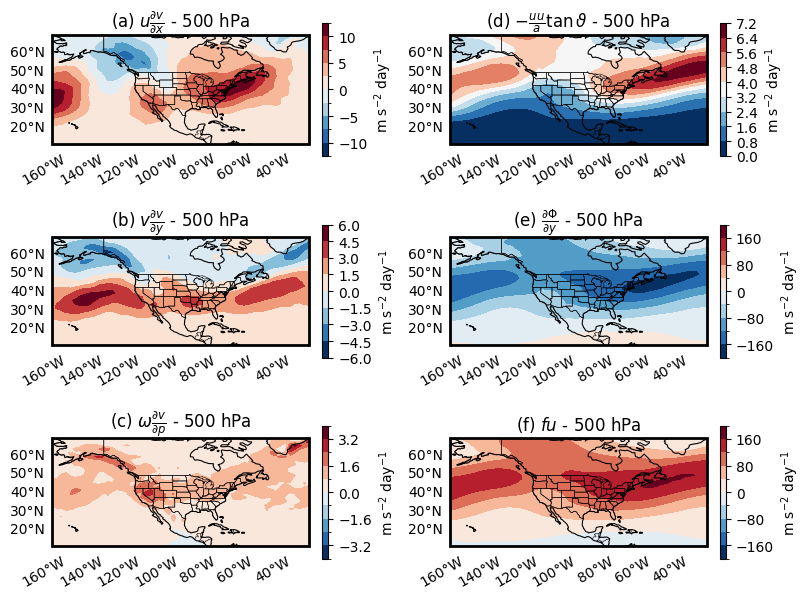

In [51]:
mean_keys = [
    r'$u\frac{\partial v}{\partial x}$',
    r'$v\frac{\partial v}{\partial y}$',
    r'$\omega\frac{\partial v}{\partial p}$',
]
# One mean term in here
eddy_keys = [
    r'$\frac{uu}{a}\tan{\vartheta}$',
    r'$\frac{\partial \Phi}{\partial y}$',
    r'$fu$', # Not an eddy term but needed it for plotting
]
fig, axes = plt.subplots(
    ncols=2, nrows=3,
    figsize=(8, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}, layout='constrained'
    )
cbar_kwargs = {'orientation':'vertical', 'shrink':0.8, 'label': r'm s$^{-2}$ day$^{-1}$'}#, 'format':'%.0e'}
plot_kwargs = {'cmap': 'RdBu_r'}#, 'vmin': -3, 'vmax': 3,} 
# Plot mean
for ax, key, label in zip(axes[:, 0], mean_keys, ['a', 'b', 'c']):
    time_mean.sel(forcing='+0K')[key].sel(plev=lev*100).plot.contourf(ax=ax, levels=11, cbar_kwargs=cbar_kwargs, **plot_kwargs)
    add_latlon(ax)
    big_ax(ax)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.add_feature(cfeature.STATES, linewidth=0.4)
    ax.set_title(f'({label}) '+key+f' - {lev} hPa')
    
# Plot eddy
for ax, key, label in zip(axes[:, 1], eddy_keys, ['d', 'e', 'f']):
    time_mean.sel(forcing='+0K')[key].sel(plev=lev*100).plot.contourf(ax=ax, levels=11, cbar_kwargs=cbar_kwargs, **plot_kwargs)
    add_latlon(ax)
    big_ax(ax)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.add_feature(cfeature.STATES, linewidth=0.4)
    ax.set_title(f'({label}) '+key+f' - {lev} hPa')
    
plt.show()

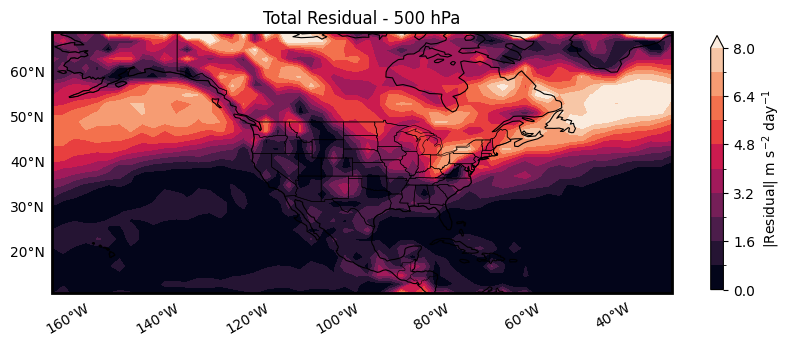

Mean Residual Value 2.7725681560430875

In [70]:
### Plot residual
fig, ax = plt.subplots(
    # ncols=2, nrows=3,
    figsize=(10, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}
)
mean_residual = np.abs(time_mean.residual.sel(forcing='+0K', plev=lev*100))
mean_residual.plot.contourf(
    ax=ax, 
    vmin=0, vmax=8,
    cmap=sns.color_palette("rocket", as_cmap=True),
    cbar_kwargs={'orientation':'vertical', 'shrink':0.55, 'label': r'|Residual| m s$^{-2}$ day$^{-1}$'},
    levels=11
)
add_latlon(ax)
big_ax(ax)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
ax.add_feature(cfeature.STATES, linewidth=0.4)
ax.set_title(f'Total Residual - {lev} hPa')
plt.show()
print('Mean Residual Value', mean_residual.mean().values)

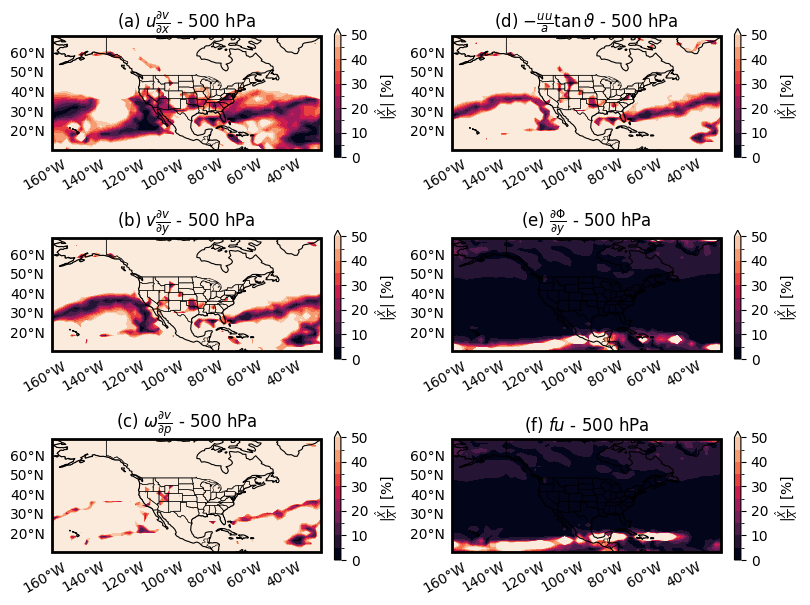

In [53]:
mean_keys = [
    r'$u\frac{\partial v}{\partial x}$',
    r'$v\frac{\partial v}{\partial y}$',
    r'$\omega\frac{\partial v}{\partial p}$',
]
# One mean term in here
eddy_keys = [
    r'$-\frac{uu}{a}\tan{\vartheta}$',
    r'$\frac{\partial \Phi}{\partial y}$',
    r'$fu$', # Not an eddy term but needed it for plotting
]
fig, axes = plt.subplots(
    ncols=2, nrows=3,
    figsize=(8, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}, layout='constrained'
    )
cbar_kwargs = {'orientation':'vertical', 'shrink':0.8, 'label': r'|$\frac{\hat{X}}{X}$| [%]'}#, 'format':'%.0e'}
cmap = sns.color_palette("rocket", as_cmap=True)
plot_kwargs = {'cmap': cmap, 'vmin': 0, 'vmax': 500,} 
# Plot mean
for ax, key, label in zip(axes[:, 0], mean_keys, ['a', 'b', 'c']):

    ratio = np.abs(mean_residual/time_mean.sel(forcing='+0K')[key].sel(plev=lev*100)) * 100
    # if label == 'c': # Set new vmin and vmax
    ratio.plot.contourf(ax=ax, levels=11, vmin=0, vmax=50, cbar_kwargs=cbar_kwargs, cmap=cmap)
    # else:
    #     ratio.plot.contourf(ax=ax, levels=11, cbar_kwargs=cbar_kwargs, **plot_kwargs)
    add_latlon(ax)
    big_ax(ax)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.add_feature(cfeature.STATES, linewidth=0.4)
    ax.set_title(f'({label}) '+key+f' - {lev} hPa')
    
# Plot eddy
for ax, key, label in zip(axes[:, 1], eddy_keys, ['d', 'e', 'f']):
    ratio = np.abs(mean_residual/time_mean.sel(forcing='+0K')[key].sel(plev=lev*100)) * 100
    # if label == 'f': # Set new vmin and vmax
    ratio.plot.contourf(ax=ax, levels=11, vmin=0, vmax=50, cbar_kwargs=cbar_kwargs, cmap=cmap)
    # else:
    #     ratio.plot.contourf(ax=ax, levels=11, cbar_kwargs=cbar_kwargs, **plot_kwargs)
    add_latlon(ax)
    big_ax(ax)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.add_feature(cfeature.STATES, linewidth=0.4)
    ax.set_title(f'({label}) '+key+f' - {lev} hPa')
plt.show()

Try deriving the terms after taking the time mean

In [54]:
test_residual = 0
for key in list(full_terms.keys()):
    # if key == '
    test_residual += time_mean[key]
test_residual.sel(forcing='+0K', plev=lev*100).mean()

<xarray.DataArray '$\\frac{\\partial v}{\\partial t}$' ()> Size: 8B
<Quantity(4.59939247, 'meter / second ** 2 / day')>
Coordinates:
    plev       float64 8B 5e+04
    forcing    <U3 12B '+0K'
    abbrevs    <U5 20B 'CONUS'
    names      <U25 100B 'Continental United States'
    metpy_crs  object 8B Projection: latitude_longitude

# Try zonal momentum

$$\left[\frac{\overline{u}}{a \cos \vartheta}\frac{\partial \overline{u}}{\partial \lambda} + \frac{\overline{v}}{a}\frac{\partial \overline{u}}{\partial \vartheta}+\overline{\omega}\frac{\partial \overline{u}}{\partial p}-f\overline{v}-\frac{\overline{u}\overline{v}}{a}\tan\vartheta+\frac{1}{a\cos\vartheta}\frac{\partial \overline{\Phi}}{\partial \lambda}\right]_{\text{mean}}\\
    + \left[\overline{\frac{u'}{a\cos\vartheta}\frac{\partial u'}{\partial \lambda}}^t+\overline{\frac{v'}{a}\frac{\partial u'}{\partial \vartheta}}^t+\overline{\omega'\frac{\partial u'}{\partial p}}^t-\overline{\frac{u'v'}{a}\tan\vartheta}^t\right]_{\text{eddy}}=0$$

In [34]:
def get_zonal_terms(ds):# Get mean state and eddy terms
    mean_vals = ds.mean('time')
    eddy_vals = ds - mean_vals
    mean = compute_derivatives(mean_vals)
    eddy = compute_derivatives(eddy_vals)
    # Terms
    u_bar = mean_vals.ua
    v_bar = mean_vals.va
    omega_bar = mean_vals.wap
    u_prime = eddy_vals.ua
    v_prime = eddy_vals.va
    omega_prime = eddy_vals.wap
    x_lambda = np.deg2rad(ds.lon) # lambda
    y_theta = np.deg2rad(ds.lat) # theta
    OMEGA = mpconst.earth_avg_angular_vel.to('s^-1') # Angular velocity of the earth
    a = mpconst.earth_avg_radius # Radius of the earth
    f = 2*OMEGA*np.sin(y_theta)
    # Now create terms
    terms = {
        r'$\overline{u}\frac{\partial \overline{u}}{\partial x}$': u_bar * mean.dudx,
        r'$\overline{v}\frac{\partial \overline{u}}{\partial y}$': v_bar * mean.dudy,
        r'$\overline{\omega}\frac{\partial \overline{u}}{\partial p}$': omega_bar * mean.dudp,
        r'-$f\overline{v}$': -f * v_bar,
        r'$-\frac{\overline{u}\overline{v}}{a}\tan{\vartheta}$': -(u_bar*v_bar)/a * np.tan(y_theta),
        r'$\frac{\partial \overline{\Phi}}{\partial x}$': mean.Phi_dudx,
        r"$\overline{u'\frac{\partial u'}{\partial x}}^t$": (u_prime * eddy.dudx).mean('time'),
        r"$\overline{v'\frac{\partial u'}{\partial y}}^t$": (v_prime * eddy.dudy).mean('time'),
        r"$\overline{\omega'\frac{\partial u'}{\partial p}}^t$": (omega_prime * mean.dudp).mean('time'),
        r"$-\overline{\frac{u'v'}{a}\tan{\vartheta}}^t$": -((u_prime * v_prime)/a * np.tan(y_theta)).mean('time'),
    }
    # Convert all terms to daily
    return_dict = {}
    for key, term in terms.items():
        return_dict[key] = term * 60 * 60 * 24 * units('day^-1')
    return return_dict
    
terms = {
        r'$\overline{u}\frac{\partial \overline{u}}{\partial x}$': [],
        r'$\overline{v}\frac{\partial \overline{u}}{\partial y}$': [],
        r'$\overline{\omega}\frac{\partial \overline{u}}{\partial p}$': [],
        r'-$f\overline{v}$': [],
        r'$-\frac{\overline{u}\overline{v}}{a}\tan{\vartheta}$': [],
        r'$\frac{\partial \overline{\Phi}}{\partial x}$': [],
        r"$\overline{u'\frac{\partial u'}{\partial x}}^t$": [],
        r"$\overline{v'\frac{\partial u'}{\partial y}}^t$": [],
        r"$\overline{\omega'\frac{\partial u'}{\partial p}}^t$": [],
        r"$-\overline{\frac{u'v'}{a}\tan{\vartheta}}^t$": [],
    }

from tqdm import tqdm 
for year in tqdm(range(1979, 2015)):
    subset = (
        ds
        .sel(time=slice(f'{year}-01-01', f'{year}-12-31')) # 1 year chunks
        # .sel(plev=[100000.,  70000.,  50000., 25000.]) # Can't filter by plev or derivatives are messed up
        .compute()
    )
    zonal_terms = get_zonal_terms(subset)
    for key, da in zonal_terms.items():
        terms[key].append(da)

x_ticks = np.arange(1979, 2015) # [1979, 2014]
flattened = []
for key, das in terms.items():
    renamed = [da.rename(key) for da in das]
    # Need to add time in
    for year, da in zip(x_ticks, renamed):
        flattened.append(da.expand_dims(dim={'time': [int(year)]}))
ds_terms_zonal = xr.merge(flattened).compute().transpose('forcing', 'time', 'plev', 'lat', 'lon')

residual = 0
for key in list(ds_terms_zonal.keys()):
    residual += ds_terms_zonal[key]
ds_terms_zonal['residual'] = residual 

100%|██████████| 36/36 [03:39<00:00,  6.09s/it]


### Magnitude of terms

In [35]:
adv_terms = [
    r'$\overline{u}\frac{\partial \overline{u}}{\partial x}$',
    r'$\overline{v}\frac{\partial \overline{u}}{\partial y}$',
    r'$\overline{\omega}\frac{\partial \overline{u}}{\partial p}$',
]
adv = 0
for k in adv_terms:
    adv += ds_terms_zonal[k]

eddy_terms = [
    r"$\overline{u'\frac{\partial u'}{\partial x}}^t$",
    r"$\overline{v'\frac{\partial u'}{\partial y}}^t$",
    r"$\overline{\omega'\frac{\partial u'}{\partial p}}^t$",
]
eddy = 0
for k in eddy_terms:
    eddy += ds_terms_zonal[k]

In [46]:
def rms_term(term):
    return np.sqrt((term**2).mean()).values
    # return np.abs(term).mean().values
    
hPa200 = {'plev': 200*100, 'forcing': '+0K'}
print('200 hPa')
print('Coriolis', rms_term(ds_terms_zonal[r'-$f\overline{v}$'].sel(hPa200)))
print('Pressure Gradient', rms_term(ds_terms_zonal[r'$\frac{\partial \overline{\Phi}}{\partial x}$'].sel(hPa200)))
print('Mean advection', rms_term(adv.sel(hPa200)))
print('Eddy advection', rms_term(eddy.sel(hPa200)))
print('Residual', rms_term(residual.sel(hPa200)))

print('\n\n925 hPa (ABL)')
hPa925 = {'plev': 925*100, 'forcing': '+0K'}
print('Coriolis', rms_term(ds_terms_zonal[r'-$f\overline{v}$'].sel(hPa925)))
print('Pressure Gradient', rms_term(ds_terms_zonal[r'$\frac{\partial \overline{\Phi}}{\partial x}$'].sel(hPa925)))
print('Mean advection', rms_term(adv.sel(hPa925)))
print('Eddy advection', rms_term(eddy.sel(hPa925)))
print('Residual', rms_term(residual.sel(hPa925)))

200 hPa

Coriolis 31.70398605518339

Pressure Gradient 32.32068751853936

Mean advection 4.392165190017741

Eddy advection 4.532905303949208

Residual 1.878915248915847

925 hPa (ABL)

Coriolis 15.3095736002325

Pressure Gradient 49.38229130796207

Mean advection 1.1466714815957963

Eddy advection 1.4477891108932692

Residual 25.67136662371719

### Plots

In [37]:
zonal_mean_state = ds_terms_zonal.mean('time')

In [38]:
lev = 500 

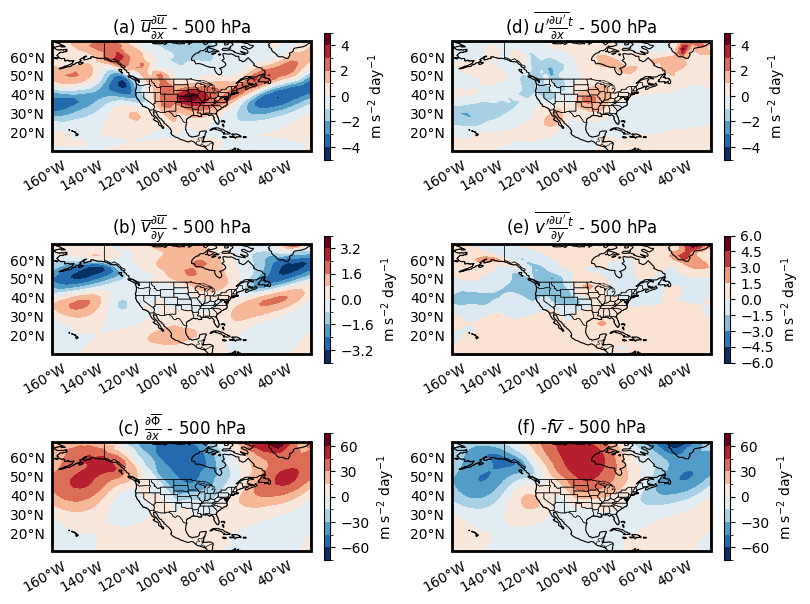

In [39]:
mean_keys = [
    '$\\overline{u}\\frac{\\partial \\overline{u}}{\\partial x}$',
    '$\\overline{v}\\frac{\\partial \\overline{u}}{\\partial y}$',
    '$\\frac{\\partial \\overline{\\Phi}}{\\partial x}$',
]
# One mean term in here
eddy_keys = [
    "$\\overline{u'\\frac{\\partial u'}{\\partial x}}^t$",
     "$\\overline{v'\\frac{\\partial u'}{\\partial y}}^t$",
    r'-$f\overline{v}$',
]
fig, axes = plt.subplots(
    ncols=2, nrows=3,
    figsize=(8, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}, layout='constrained'
    )
cbar_kwargs = {'orientation':'vertical', 'shrink':0.8, 'label': r'm s$^{-2}$ day$^{-1}$'}#, 'format':'%.0e'}
plot_kwargs = {'cmap': 'RdBu_r'}#, 'vmin': -3, 'vmax': 3,} 
# Plot mean
for ax, key, label in zip(axes[:, 0], mean_keys, ['a', 'b', 'c']):
    zonal_mean_state.sel(forcing='+0K')[key].sel(plev=lev*100).plot.contourf(ax=ax, levels=11, cbar_kwargs=cbar_kwargs, **plot_kwargs)
    add_latlon(ax)
    big_ax(ax)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.add_feature(cfeature.STATES, linewidth=0.4)
    ax.set_title(f'({label}) '+key+f' - {lev} hPa')
    
# Plot eddy
for ax, key, label in zip(axes[:, 1], eddy_keys, ['d', 'e', 'f']):
    zonal_mean_state.sel(forcing='+0K')[key].sel(plev=lev*100).plot.contourf(ax=ax, levels=11, cbar_kwargs=cbar_kwargs, **plot_kwargs)
    add_latlon(ax)
    big_ax(ax)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.add_feature(cfeature.STATES, linewidth=0.4)
    ax.set_title(f'({label}) '+key+f' - {lev} hPa')
    
plt.show()

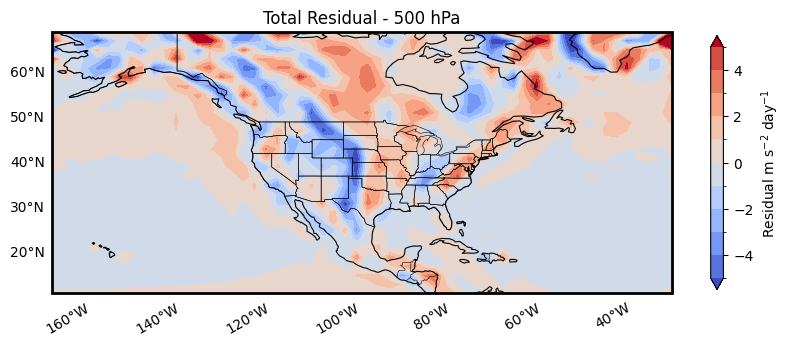

In [42]:
### Plot residual
fig, ax = plt.subplots(
    # ncols=2, nrows=3,
    figsize=(10, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}
)
mean_residual = (zonal_mean_state.sel(forcing='+0K', plev=lev*100)['residual'])
mean_residual.plot.contourf(
    ax=ax, 
    vmin=-5, vmax=5,
    cmap='coolwarm',#sns.color_palette("rocket", as_cmap=True), 
    cbar_kwargs={'orientation':'vertical', 'shrink':0.55, 'label': r'Residual m s$^{-2}$ day$^{-1}$'},
    levels=11
)
add_latlon(ax)
big_ax(ax)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
ax.add_feature(cfeature.STATES, linewidth=0.4)
ax.set_title(f'Total Residual - {lev} hPa')
plt.show()
# print('Mean Residual Value', np.abs(mean_residual).mean().values)

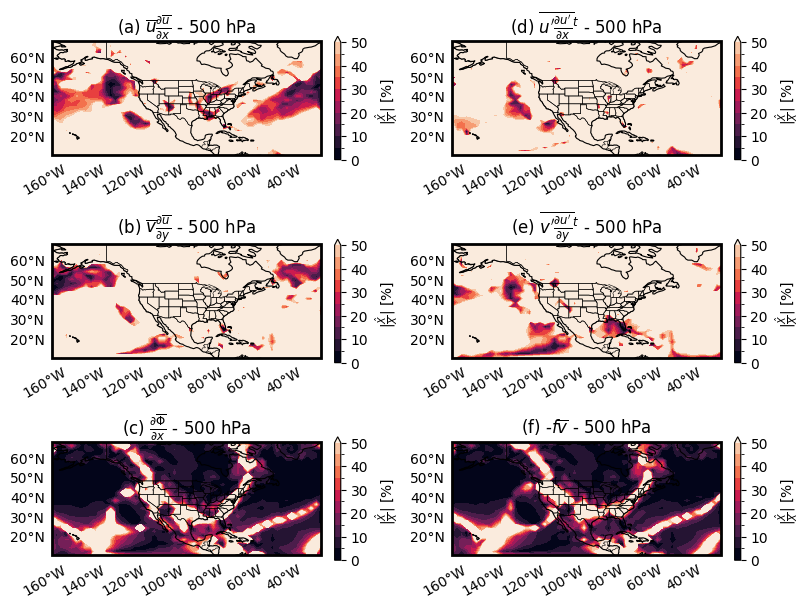

In [233]:
mean_keys = [
    '$\\overline{u}\\frac{\\partial \\overline{u}}{\\partial x}$',
    '$\\overline{v}\\frac{\\partial \\overline{u}}{\\partial y}$',
    '$\\frac{\\partial \\overline{\\Phi}}{\\partial x}$',
]
# One mean term in here
eddy_keys = [
    "$\\overline{u'\\frac{\\partial u'}{\\partial x}}^t$",
     "$\\overline{v'\\frac{\\partial u'}{\\partial y}}^t$",
    r'-$f\overline{v}$',
]
fig, axes = plt.subplots(
    ncols=2, nrows=3,
    figsize=(8, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}, layout='constrained'
    )
cbar_kwargs = {'orientation':'vertical', 'shrink':0.8, 'label': r'|$\frac{\hat{X}}{X}$| [%]'}#, 'format':'%.0e'}
cmap = sns.color_palette("rocket", as_cmap=True)
plot_kwargs = {'cmap': cmap, 'vmin': 0, 'vmax': 50,} 
# Plot mean
for ax, key, label in zip(axes[:, 0], mean_keys, ['a', 'b', 'c']):

    ratio = np.abs(mean_residual/zonal_mean_state.sel(forcing='+0K')[key].sel(plev=lev*100)) * 100
    ratio.plot.contourf(ax=ax, levels=11, cbar_kwargs=cbar_kwargs, **plot_kwargs)
    add_latlon(ax)
    big_ax(ax)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.add_feature(cfeature.STATES, linewidth=0.4)
    ax.set_title(f'({label}) '+key+f' - {lev} hPa')
    
# Plot eddy
for ax, key, label in zip(axes[:, 1], eddy_keys, ['d', 'e', 'f']):
    ratio = np.abs(mean_residual/zonal_mean_state.sel(forcing='+0K')[key].sel(plev=lev*100)) * 100
    # if label == 'f': # Set new vmin and vmax
    ratio.plot.contourf(ax=ax, levels=11, cbar_kwargs=cbar_kwargs, **plot_kwargs)
    add_latlon(ax)
    big_ax(ax)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.add_feature(cfeature.STATES, linewidth=0.4)
    ax.set_title(f'({label}) '+key+f' - {lev} hPa')
plt.show()

## Zonal momentum from Yang et al. (2013)
"Zonal Momentum Balance in the Tropical Atmospheric Circulation during the Global Monsoon Mature Months"

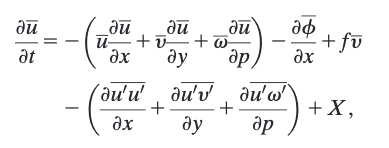

Overlines are the multi year average for a specific month

In [20]:
subset = ds.sel(time=(ds.time.dt.month == 6)) # June data
mean_vals = subset.mean('time')
eddy_vals = subset - mean_vals
mean = compute_derivatives(mean_vals)
eddy = compute_derivatives(eddy_vals)
# Terms
u_bar = mean_vals.ua
v_bar = mean_vals.va
omega_bar = mean_vals.wap
u_prime = eddy_vals.ua
v_prime = eddy_vals.va
omega_prime = eddy_vals.wap
x_lambda = np.deg2rad(ds.lon) # lambda
y_theta = np.deg2rad(ds.lat) # theta
OMEGA = mpconst.earth_avg_angular_vel.to('s^-1') # Angular velocity of the earth
a = mpconst.earth_avg_radius # Radius of the earth
f = 2*OMEGA*np.sin(y_theta)

# New terms
# uu_x = mpcalc.first_derivative((u_prime*u_prime).mean('time'), axis='lon')
# uv_y = mpcalc.first_derivative((u_prime*v_prime).mean('time'), axis='lat')
# uomega_p = mpcalc.first_derivative((u_prime*omega_prime).mean('time'), axis='plev')

# Now create terms
zonal_terms = {
    r'$\overline{u}\frac{\partial \overline{u}}{\partial x}$': u_bar * mean.dudx,
    r'$\overline{v}\frac{\partial \overline{u}}{\partial y}$': v_bar * mean.dudy,
    r'$\overline{\omega}\frac{\partial \overline{u}}{\partial p}$': omega_bar * mean.dudp,
    r'-$f\overline{v}$': -f * v_bar,
    r'$-\frac{\overline{u}\overline{v}}{a}\tan{\vartheta}$': -(u_bar*v_bar)/a * np.tan(y_theta),
    r'$\frac{\partial \overline{\Phi}}{\partial x}$': mean.Phi_dudx,
    r"$\overline{\frac{\partial \overline{u'u'}}{\partial x}}^t$": (u_prime * eddy.dudx).mean('time'),
    r"$\overline{\frac{\partial \overline{u'v'}}{\partial y}}^t$": (v_prime * eddy.dudy).mean('time'),
    r"$\overline{'\frac{\partial \overline{u'\omega'}}{\partial p}}^t$": (omega_prime * eddy.dudp).mean('time'),
    r"$-\overline{\frac{u'v'}{a}\tan{\vartheta}}^t$": -((u_prime * v_prime)/a * np.tan(y_theta)).mean('time'),
}
residual = 0
for key in list(zonal_terms.keys()):
    residual += zonal_terms[key]

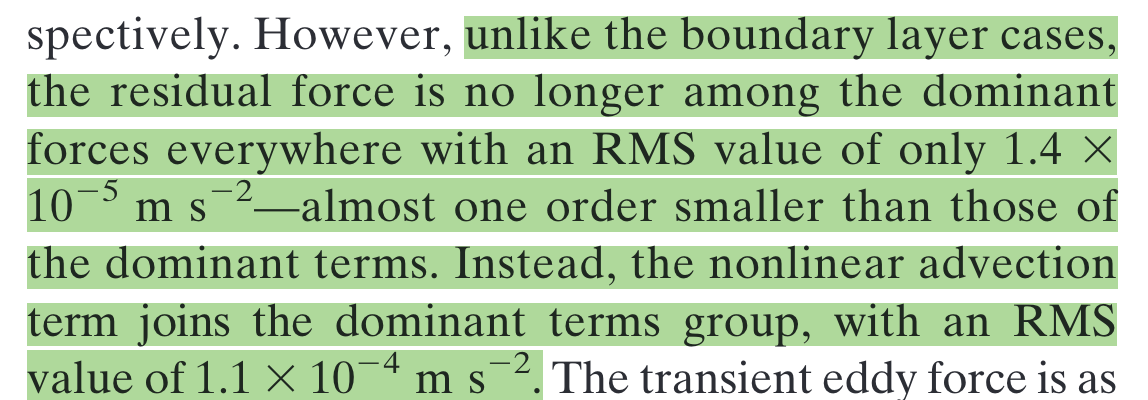

In [21]:
def rms_term(term):
    return np.sqrt((term**2).mean()).values
    
adv_terms = [
    r'$\overline{u}\frac{\partial \overline{u}}{\partial x}$',
    r'$\overline{v}\frac{\partial \overline{u}}{\partial y}$',
    r'$\overline{\omega}\frac{\partial \overline{u}}{\partial p}$'
]
adv = 0
for k in adv_terms:
    adv += zonal_terms[k]

eddy_terms = [
    r"$\overline{\frac{\partial \overline{u'u'}}{\partial x}}^t$",
    r"$\overline{\frac{\partial \overline{u'v'}}{\partial y}}^t$",
    r"$\overline{'\frac{\partial \overline{u'\omega'}}{\partial p}}^t$"
]
eddy = 0
for k in eddy_terms:
    eddy += zonal_terms[k]

200 hPa

In [22]:
hPa200 = {'plev': 200*100, 'forcing': '+0K'}
print('Coriolis', rms_term(zonal_terms[r'-$f\overline{v}$'].sel(hPa200)))
print('Pressure Gradient', rms_term(zonal_terms[r'$\frac{\partial \overline{\Phi}}{\partial x}$'].sel(hPa200)))
print('Mean advection', rms_term(adv.sel(hPa200)))
print('Eddy advection', rms_term(eddy.sel(hPa200)))
print('Residual', rms_term(residual.sel(hPa200)))

Coriolis 0.0003212878196363928

Pressure Gradient 0.0003277759284727345

Mean advection 4.1599889498174145e-05

Eddy advection 3.020222207341123e-05

Residual 2.5016469683035865e-05

Same thing for the ABL

In [23]:
hPa925 = {'plev': 925*100, 'forcing': '+0K'}
print('Coriolis', rms_term(zonal_terms[r'-$f\overline{v}$'].sel(hPa925)))
print('Pressure Gradient', rms_term(zonal_terms[r'$\frac{\partial \overline{\Phi}}{\partial x}$'].sel(hPa925)))
print('Mean advection', rms_term(adv.sel(hPa925)))
print('Eddy advection', rms_term(eddy.sel(hPa925)))
print('Residual', rms_term(residual.sel(hPa925)))

Coriolis 0.000192004247894816

Pressure Gradient 0.0003504499720362427

Mean advection 1.4616780553594543e-05

Eddy advection 1.1875883599221493e-05

Residual 0.00018420747721765006